In [ ]:
 # !pip install tensorflow-transform

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
%load_ext tensorboard

In [ ]:
import os
import datetime
import time
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# import tensorflow_transform as tft
from sklearn.preprocessing import MinMaxScaler

plt.rc('font',family='NanumBarunGothic')
mpl.rcParams['figure.figsize']=(20,18)
mpl.rcParams['axes.grid']=False

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
df = pd.read_csv(r'/content/sample_data/용산_모델학습데이터_2020-06-20~2021-05-14.csv',encoding='cp949')
try:
  df.drop(['Unnamed: 0'],axis=1,inplace=True)
  #df.drop(['돼지국밥','순대국'],axis=1, inplace=True)
except:
  pass

df.head(5)

날짜  월  화  수  목  금  토  ...  습도  전운량  증하층운량  지면온도  대구  전국    매출액
0  2020-06-20 18:00:00  0  0  0  0  0  1  ...  47    1      0  33.4   2  32  14000
1  2020-06-20 19:00:00  0  0  0  0  0  1  ...  49    0      0  28.6   2  32      0
2  2020-06-20 20:00:00  0  0  0  0  0  1  ...  61    3      0  25.7   2  32      0
3  2020-06-20 21:00:00  0  0  0  0  0  1  ...  67    3      0  24.0   2  32      0
4  2020-06-20 22:00:00  0  0  0  0  0  1  ...  70    3      0  22.7   2  32      0

[5 rows x 47 columns]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


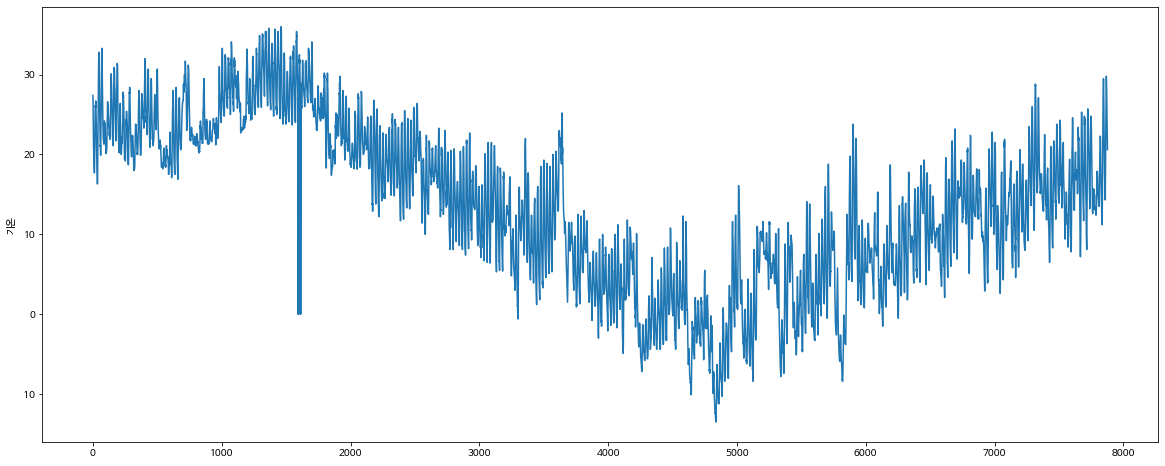

In [ ]:
plt.figure(figsize=(20,8))
plt.ylabel("기온")
plt.plot(range(len(df)),df[['기온']])

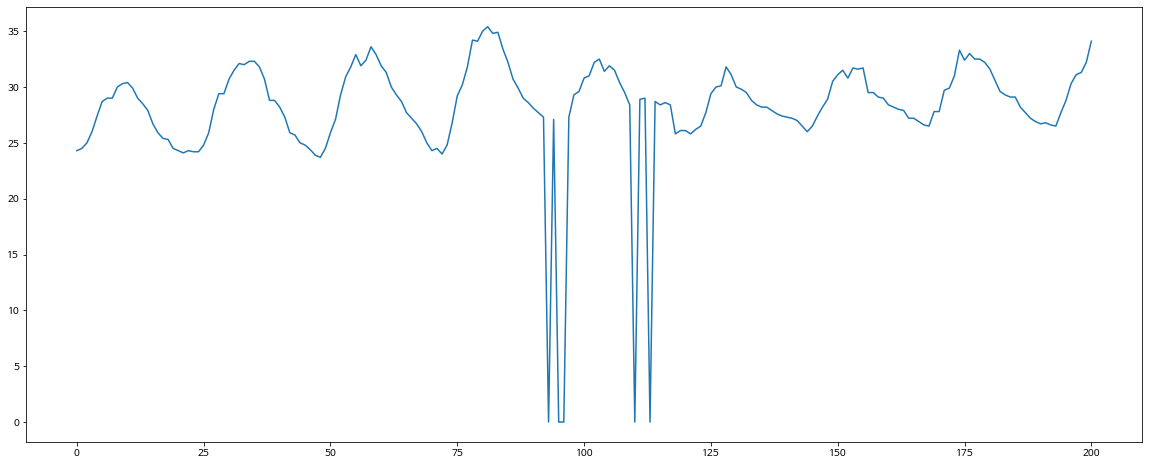

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(range(len(df.loc[1500:1700])),df.loc[1500:1700]['기온'])

In [ ]:
## 기온 이상치 처리

df['기온_shift1'] = df['기온'].shift(1)
df['기온_shift-1'] = df['기온'].shift(-1)
idx_list1 = df[(df['기온']-df['기온_shift1'])<-20].index
idx_list2 = df[(df['기온']-df['기온_shift-1'])<-20]['기온'].index
idx_set = set(idx_list1.tolist() + idx_list2.tolist())

for idx in idx_set:
  if abs(df.loc[idx,'기온_shift1']-df.loc[idx,'기온_shift-1'])<20:
    df.loc[idx,'기온'] = (df.loc[idx,'기온_shift1'] + df.loc[idx,'기온_shift-1'])/2
  elif abs(df.loc[idx,'기온_shift1']-df.loc[idx+1,'기온_shift-1'])<20:
    df.loc[idx,'기온'] = (df.loc[idx,'기온_shift1'] + df.loc[idx+1,'기온_shift-1'])/2
  else:
    df.loc[idx,'기온'] = (df.loc[idx-1,'기온_shift1'] + df.loc[idx,'기온_shift-1'])/2

df.drop(['기온_shift1'],axis=1,inplace=True)
df.drop(['기온_shift-1'],axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


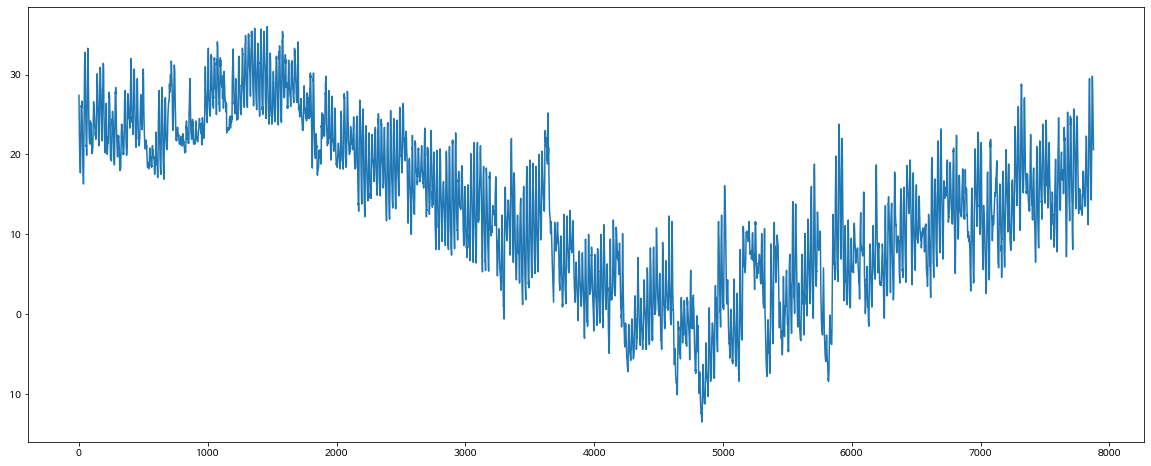

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(range(len(df)),df[['기온']])

In [ ]:
pd.options.display.max_rows = 20

df['시간'] = df.apply(lambda x:int(x['날짜'][11:13]),axis=1)
df[((df['시간']>8) & (df['시간']<23))]['시간']

0       18
1       19
2       20
3       21
4       22
        ..
7872    18
7873    19
7874    20
7875    21
7876    22
Name: 시간, Length: 4597, dtype: int64

In [ ]:
df = df[((df['시간']>8) & (df['시간']<23))]
df = df.iloc[5:]
df.reset_index(drop=True,inplace=True)
df.drop(['시간','23시','00시','01시','02시','03시','04시','05시','06시','07시','08시'],axis=1,inplace=True)
df

날짜  월  화  수  목  금  ...  전운량  증하층운량  지면온도  대구   전국     매출액
0     2020-06-21 09:00:00  0  0  0  0  0  ...    2      0  31.6   1   36       0
1     2020-06-21 10:00:00  0  0  0  0  0  ...    2      0  36.3   1   36   71000
2     2020-06-21 11:00:00  0  0  0  0  0  ...    3      0  41.2   1   36   15000
3     2020-06-21 12:00:00  0  0  0  0  0  ...    6      0  40.5   1   36   97500
4     2020-06-21 13:00:00  0  0  0  0  0  ...    6      0  38.2   1   36   44000
...                   ... .. .. .. .. ..  ...  ...    ...   ...  ..  ...     ...
4587  2021-05-14 18:00:00  0  0  0  0  1  ...    8      2  30.2   9  729   52000
4588  2021-05-14 19:00:00  0  0  0  0  1  ...    6      0  26.4   9  729  153500
4589  2021-05-14 20:00:00  0  0  0  0  1  ...    4      0  23.5   9  729   81500
4590  2021-05-14 21:00:00  0  0  0  0  1  ...    8      4  22.4   9  729   83000
4591  2021-05-14 22:00:00  0  0  0  0  1  ...    7      6  21.4   9  729  115000

[4592 rows x 37 columns]

In [ ]:
date_time = pd.to_datetime(df.pop('날짜'), format='%Y-%m-%d %H:%M:%S')

In [ ]:
date_time

0      2020-06-21 09:00:00
1      2020-06-21 10:00:00
2      2020-06-21 11:00:00
3      2020-06-21 12:00:00
4      2020-06-21 13:00:00
               ...        
4587   2021-05-14 18:00:00
4588   2021-05-14 19:00:00
4589   2021-05-14 20:00:00
4590   2021-05-14 21:00:00
4591   2021-05-14 22:00:00
Name: 날짜, Length: 4592, dtype: datetime64[ns]

In [ ]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [ ]:
### 0과1로 분류한 데이터들을 category로 분류 데이터임을 명시

df[df.columns.tolist()[:24]] = df[df.columns.tolist()[:24]].astype('category')
df[df.columns.tolist()[:24]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4592 entries, 0 to 4591
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   월       4592 non-null   category
 1   화       4592 non-null   category
 2   수       4592 non-null   category
 3   목       4592 non-null   category
 4   금       4592 non-null   category
 5   토       4592 non-null   category
 6   일       4592 non-null   category
 7   09시     4592 non-null   category
 8   10시     4592 non-null   category
 9   11시     4592 non-null   category
 10  12시     4592 non-null   category
 11  13시     4592 non-null   category
 12  14시     4592 non-null   category
 13  15시     4592 non-null   category
 14  16시     4592 non-null   category
 15  17시     4592 non-null   category
 16  18시     4592 non-null   category
 17  19시     4592 non-null   category
 18  20시     4592 non-null   category
 19  21시     4592 non-null   category
 20  22시     4592 non-null   category
 21  공휴일     4592 n

In [ ]:
df.describe().transpose()

count          mean  ...          75%           max
돼지국밥   4592.0     37.604455  ...     40.68364      68.43610
순대국    4592.0     38.706375  ...     41.69347      56.58623
기온     4592.0     15.506762  ...     23.00000      36.00000
강수량    4592.0      0.138894  ...      0.00000      27.80000
풍속     4592.0      2.761302  ...      3.80000       9.50000
습도     4592.0     56.756969  ...     69.00000     100.00000
전운량    4592.0      5.019817  ...      9.00000      10.00000
증하층운량  4592.0      3.035497  ...      6.00000      10.00000
지면온도   4592.0     19.052243  ...     27.60000      58.50000
대구     4592.0      7.375000  ...     12.00000      49.00000
전국     4592.0    337.652439  ...    512.50000    1216.00000
매출액    4592.0  56569.795296  ...  81000.00000  486500.00000

[12 rows x 8 columns]

In [ ]:
## 결제 취소를 통해 발생한 마이너스 매출 처리

sales_minus_list = df[df['매출액']<0].index

for idx in sales_minus_list:
  df.loc[idx,'매출액'] = 0

df[df['매출액']<0]

Empty DataFrame
Columns: [월, 화, 수, 목, 금, 토, 일, 09시, 10시, 11시, 12시, 13시, 14시, 15시, 16시, 17시, 18시, 19시, 20시, 21시, 22시, 공휴일, 24절기, 잡절, 돼지국밥, 순대국, 기온, 강수량, 풍속, 습도, 전운량, 증하층운량, 지면온도, 대구, 전국, 매출액]
Index: []

In [ ]:
## 매출액 데이터를 로그변환 : 기존 데이터가 정규분포를 따르지 않으므로 정규분포에 근사한 데이터를 만들기 위해 로그를 취함.
## 특정 데이터에만 임의로 값을 적용하는 것이 아니라, 모든 데이터에 동일한 값을 적용

#zero_idx_list = df[df['매출액']==0.1].index
#df.loc[:,'매출액'] += 0.01
#df

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


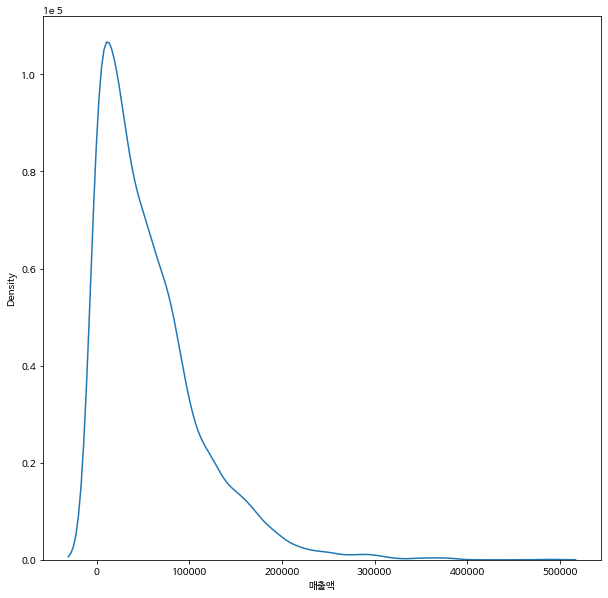

In [ ]:
plt.figure(figsize=(10,10))
sns.distplot(df['매출액'],hist=False)
plt.show()

In [ ]:
#df['매출액'] = df['매출액'].map(lambda x:np.log(x))
#df

In [ ]:
#plt.figure(figsize=(10,10))
#sns.distplot(np.log(df['매출액']),hist=False)
#plt.show()

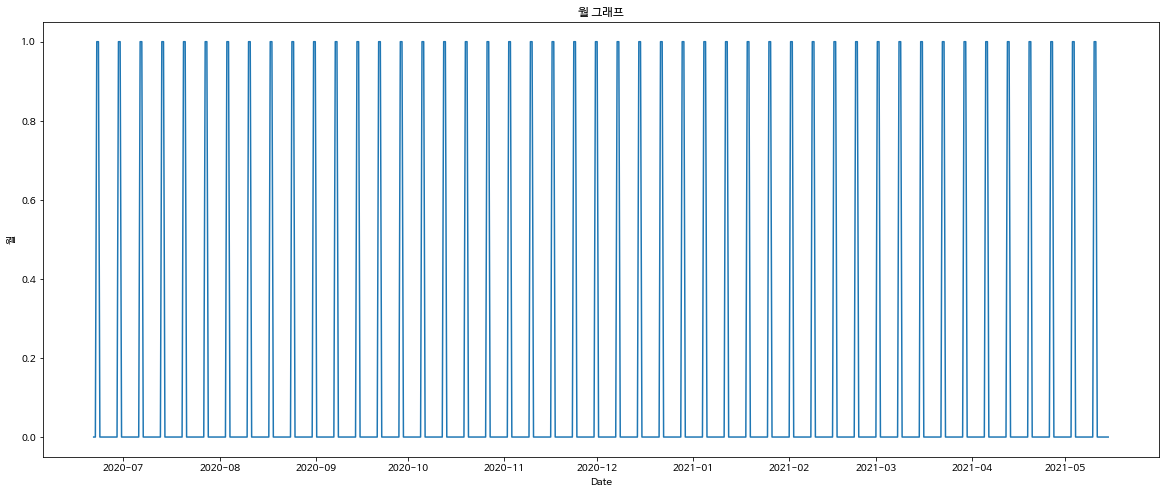

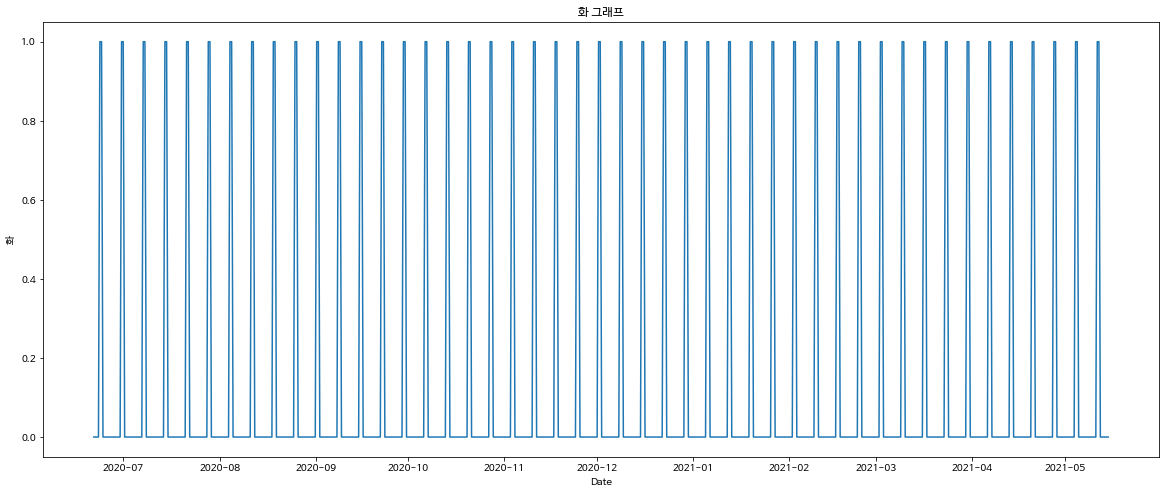

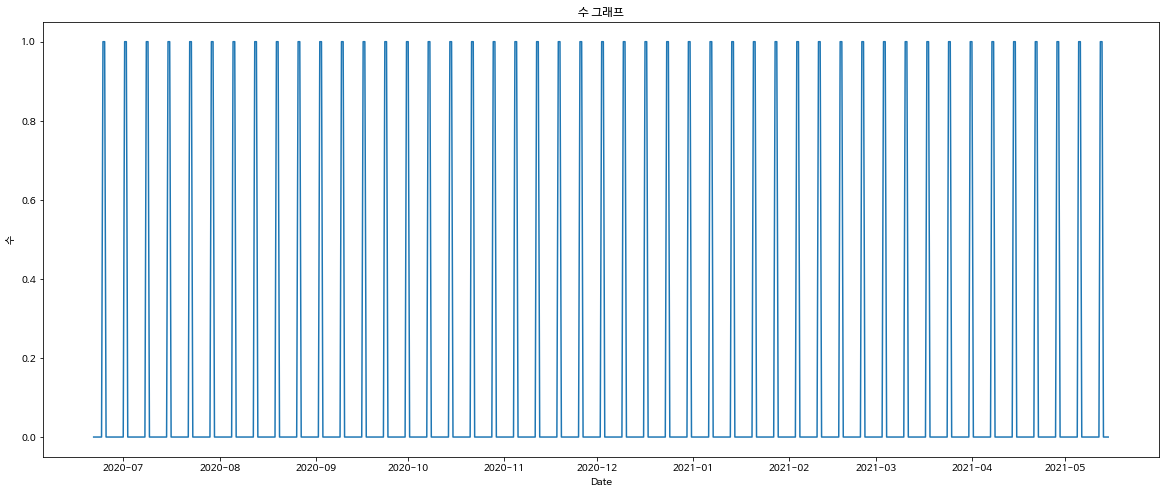

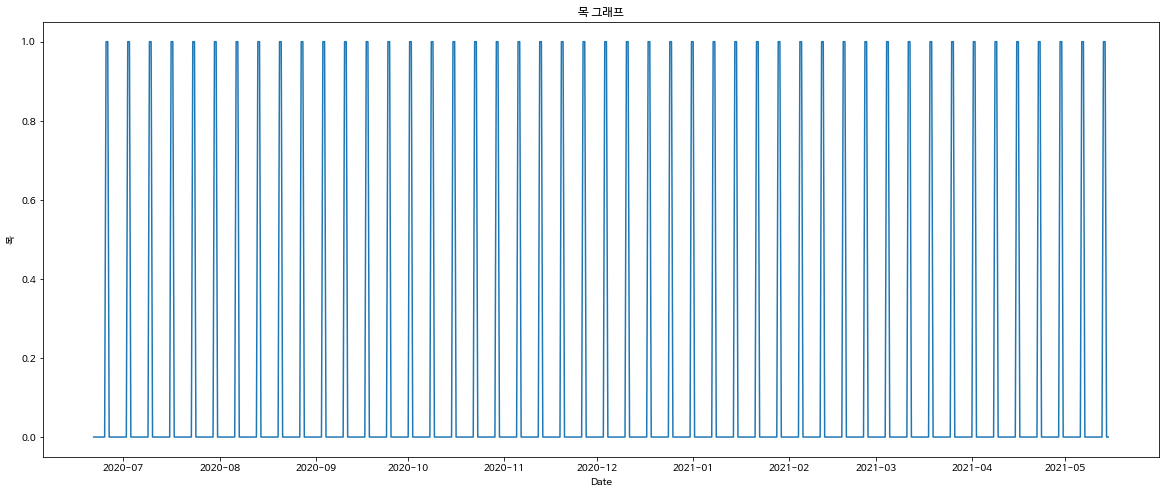

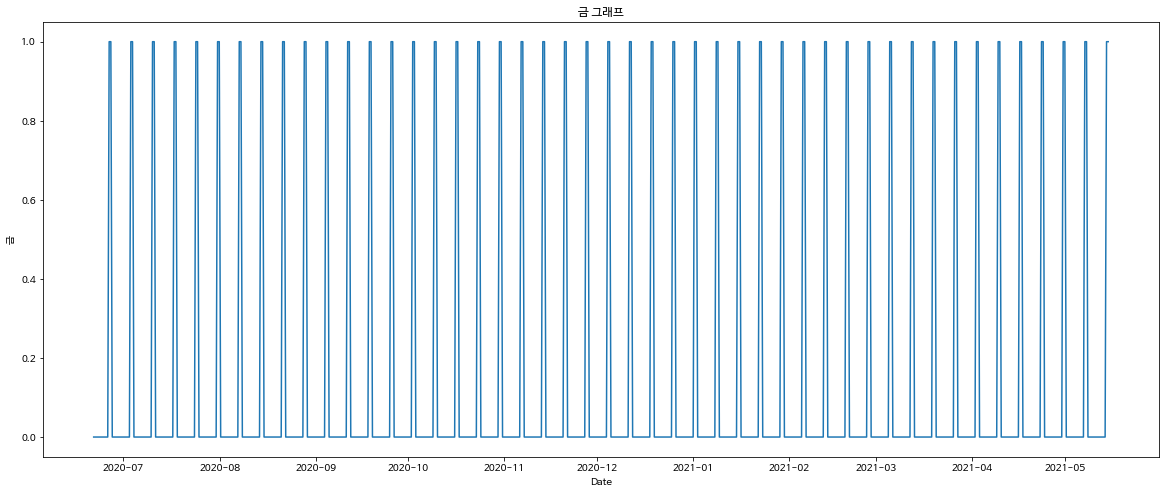

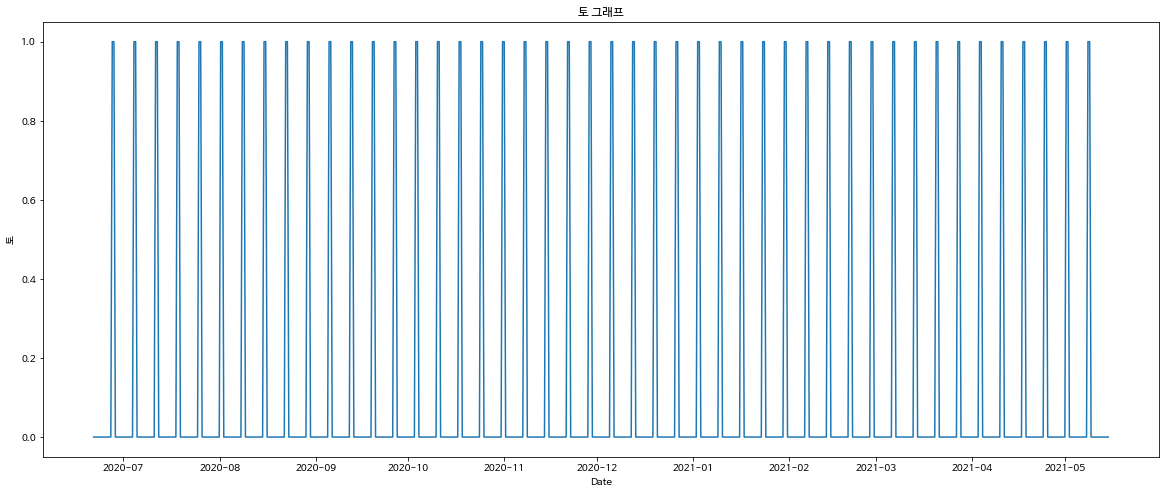

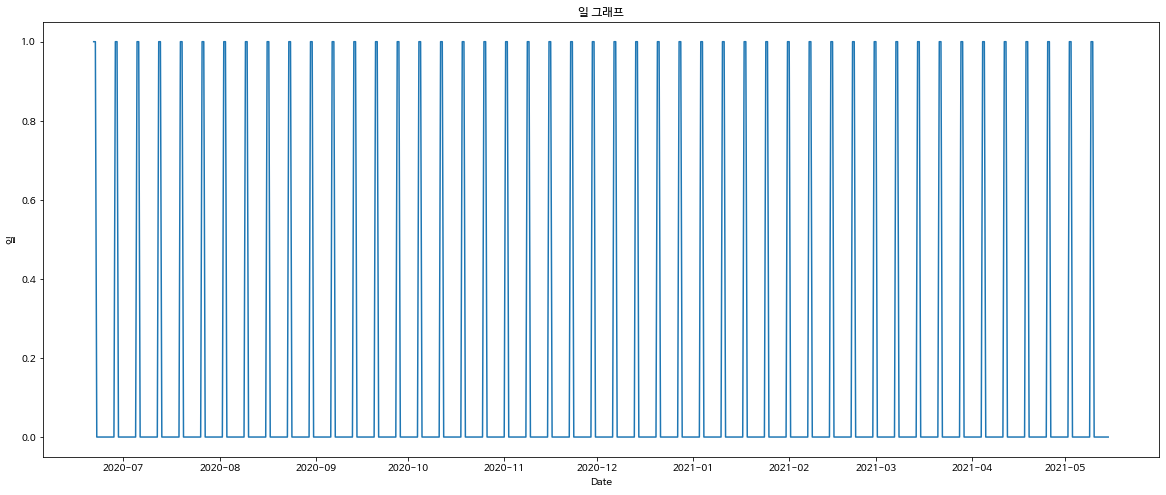

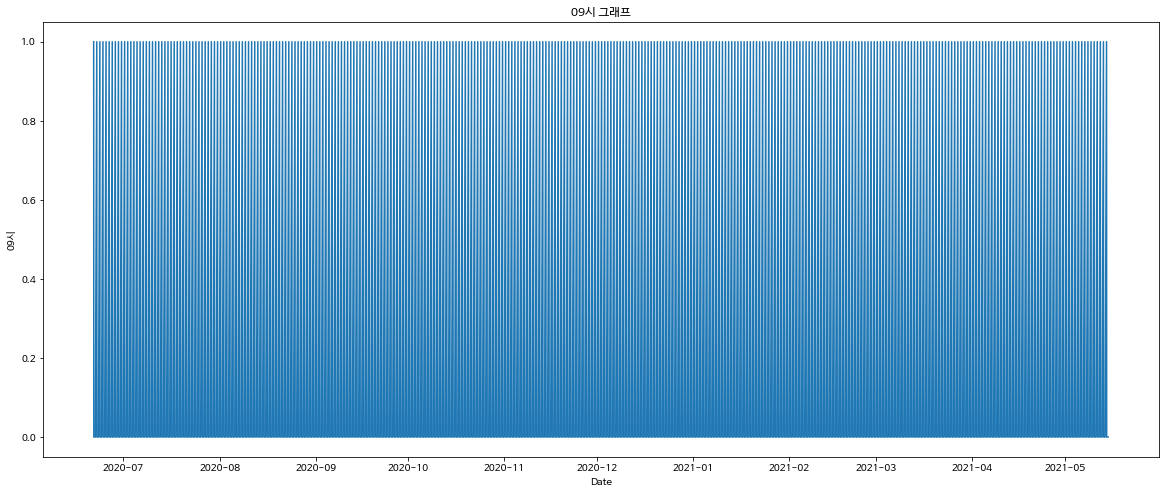

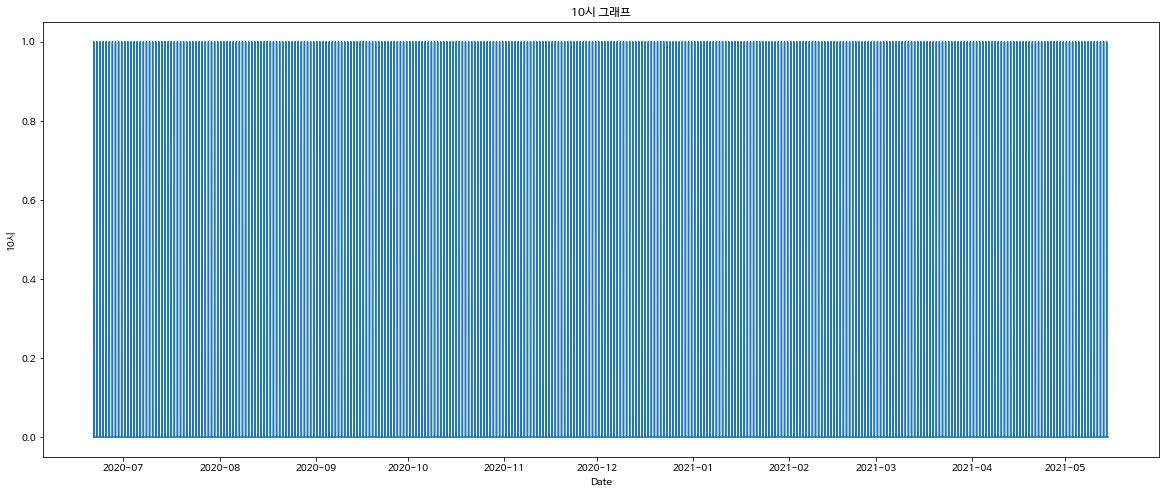

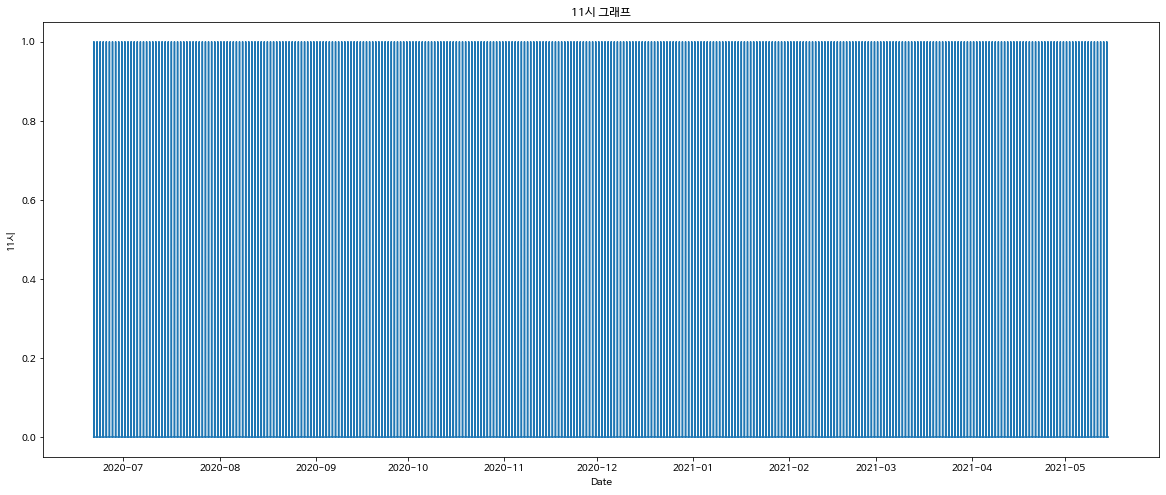

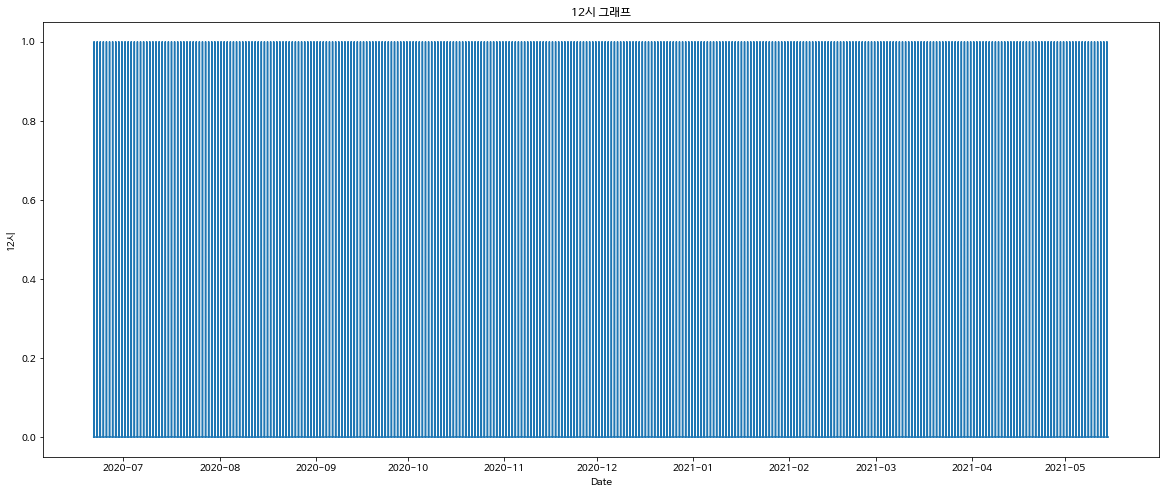

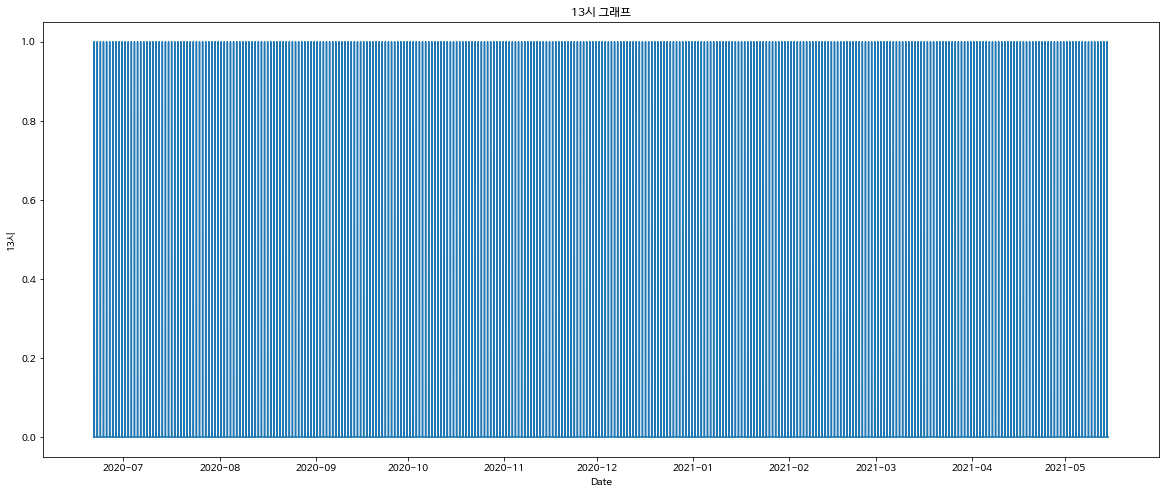

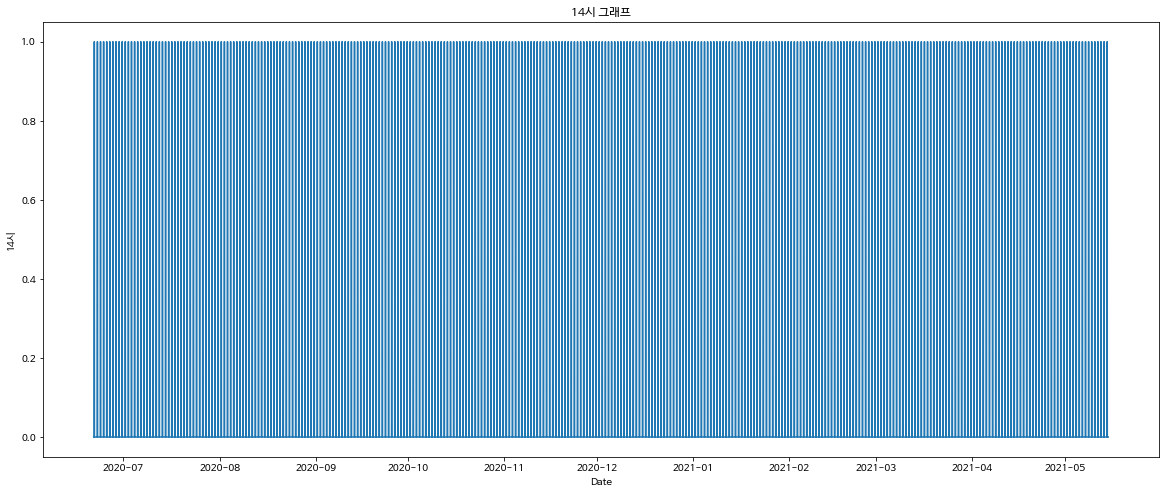

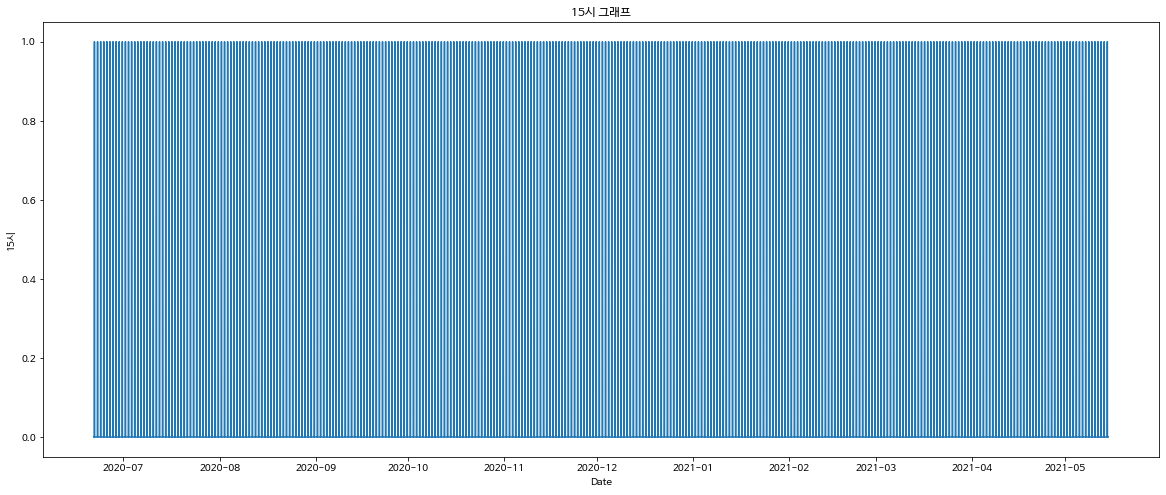

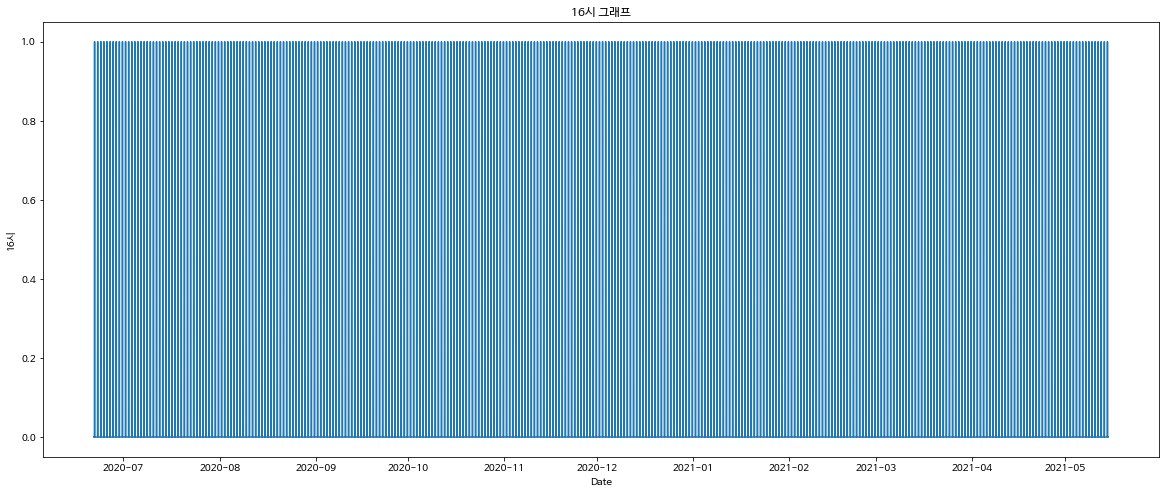

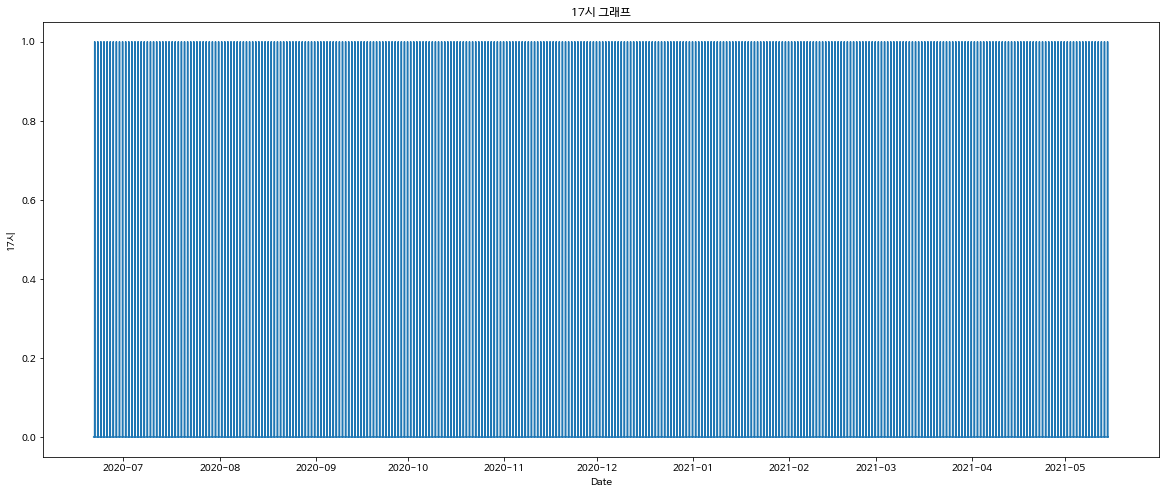

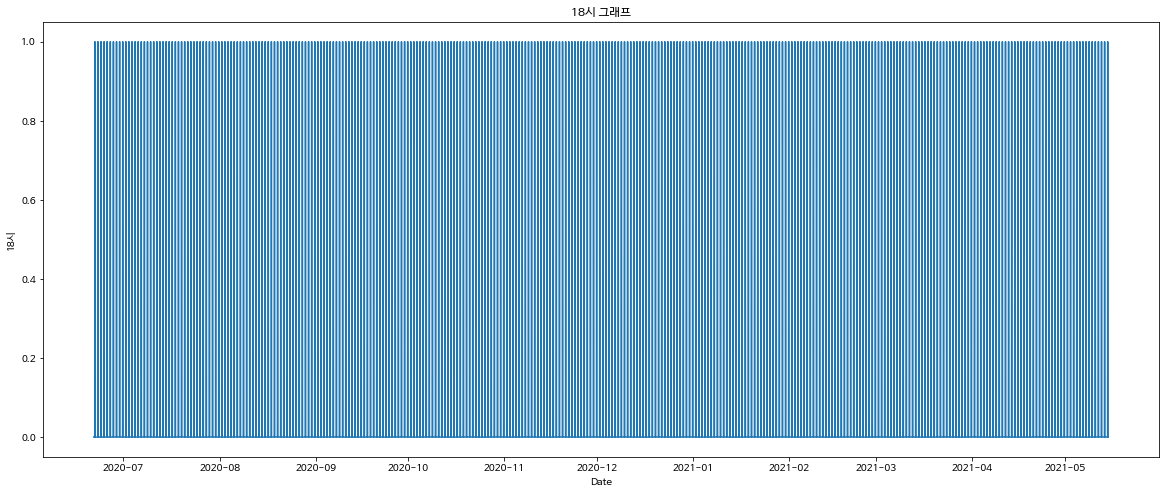

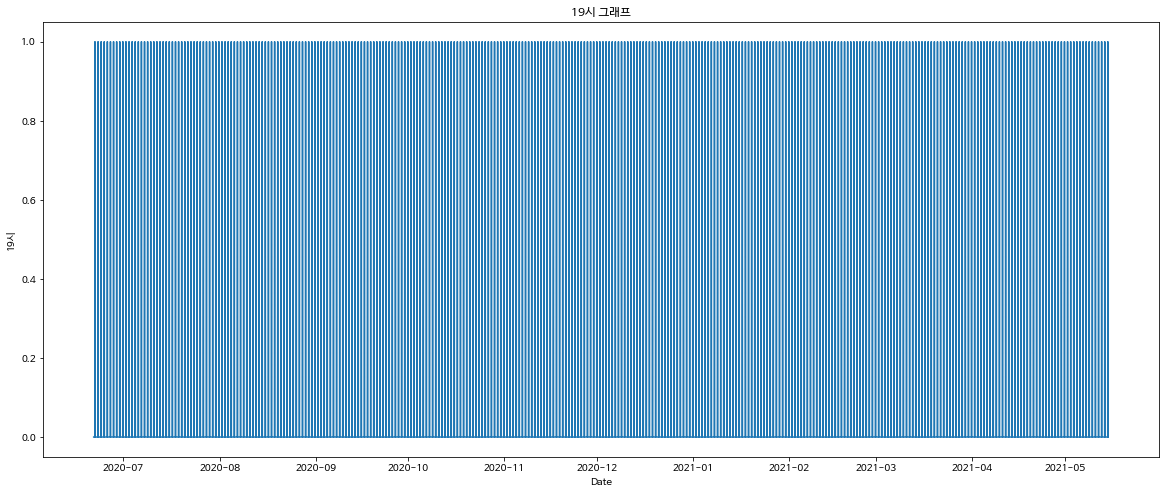

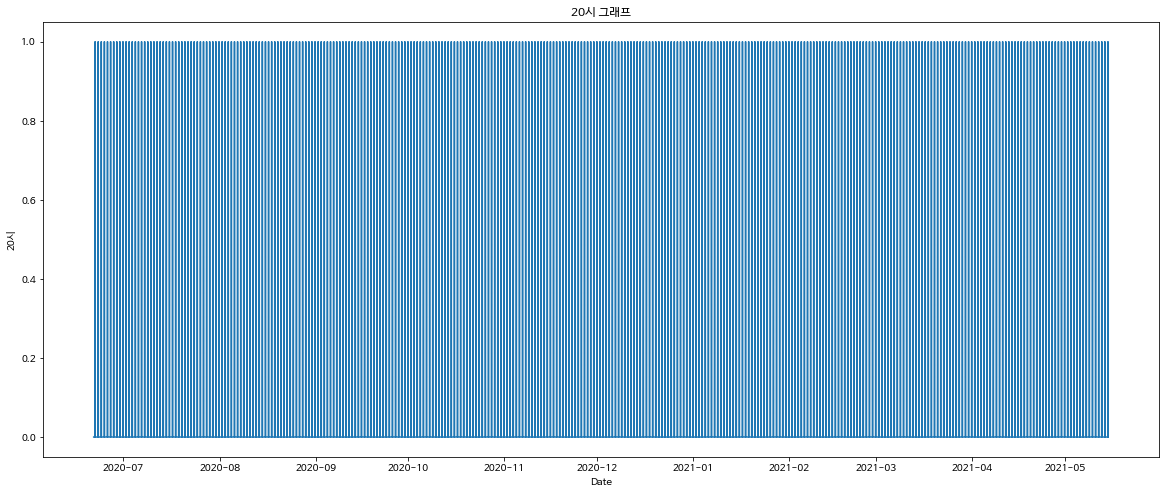

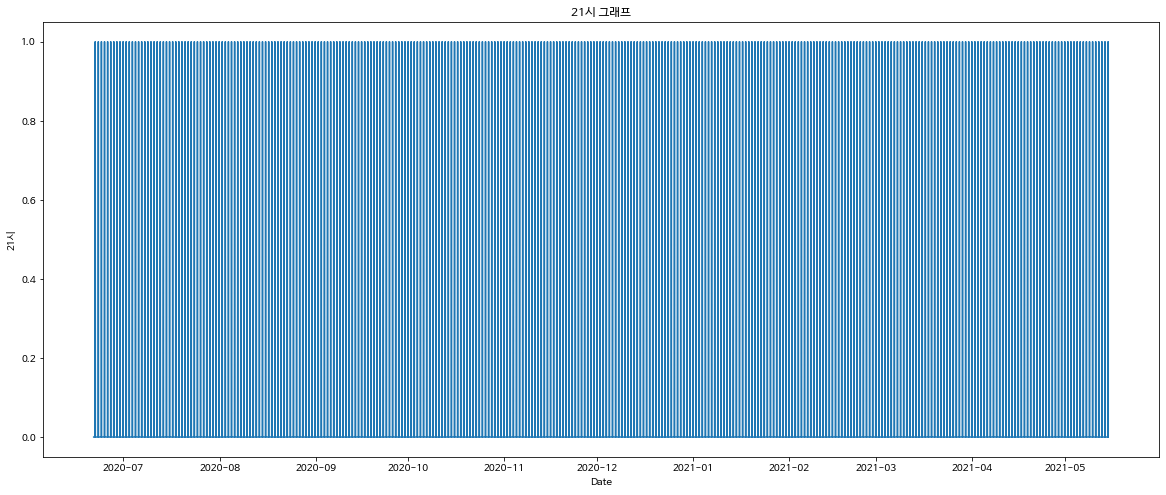

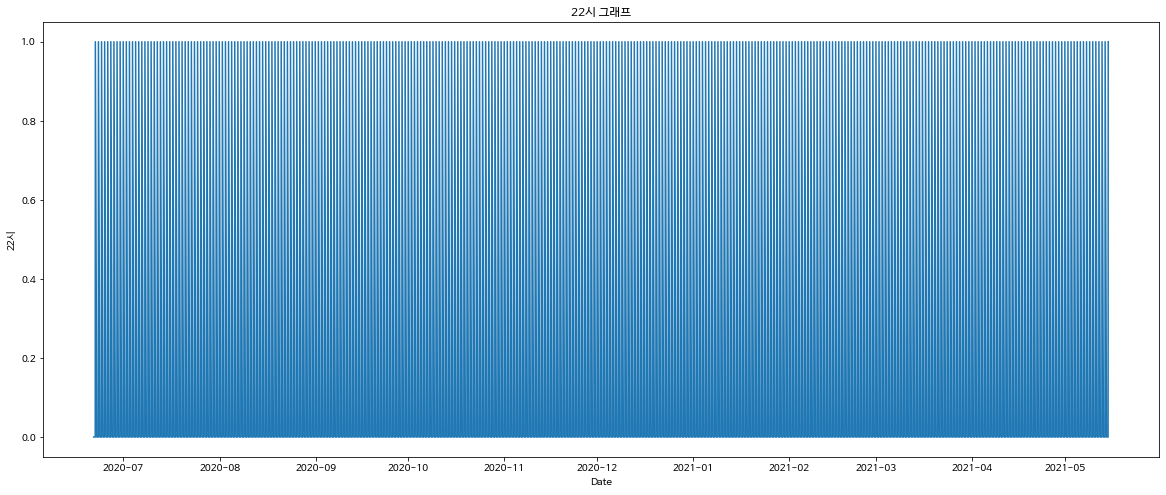

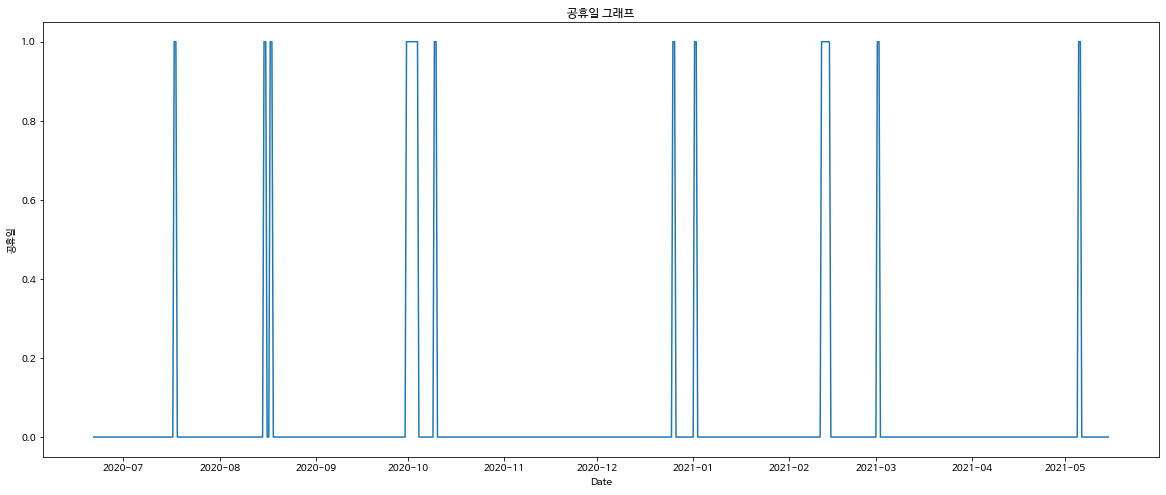

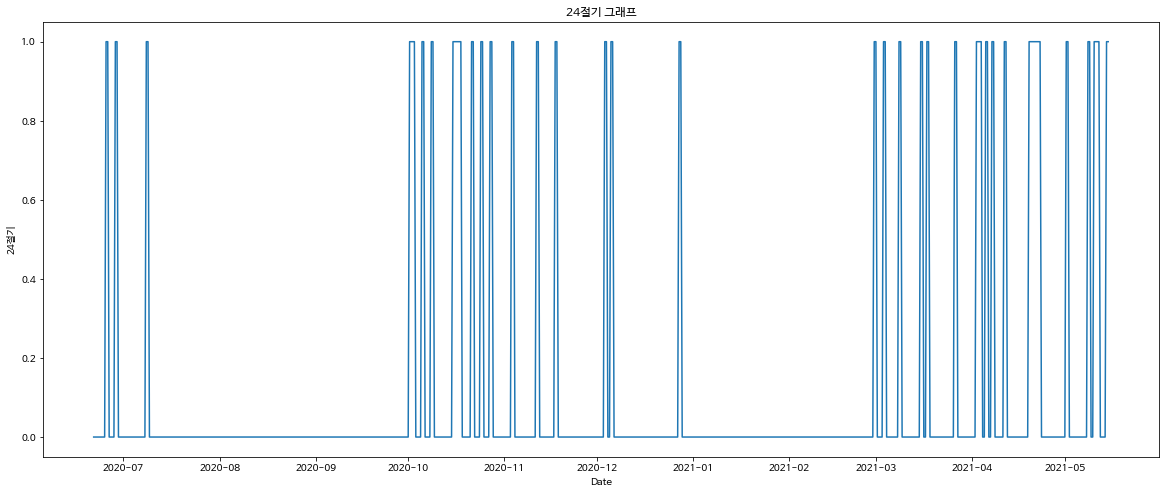

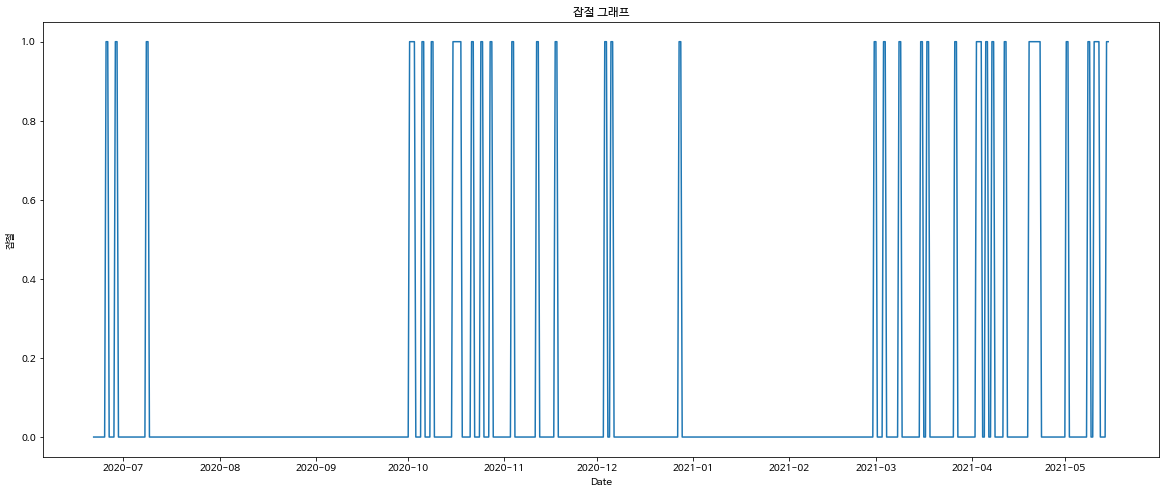

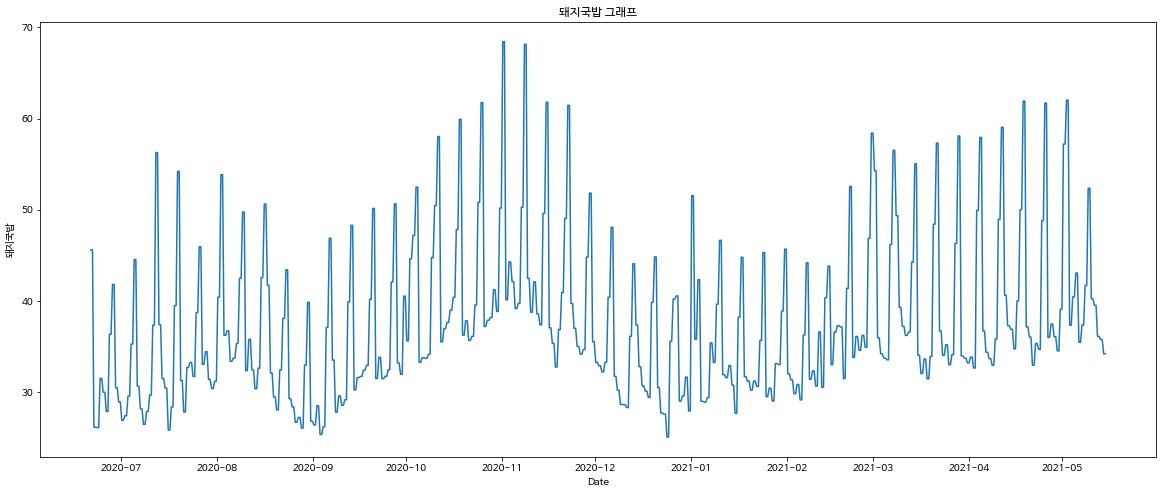

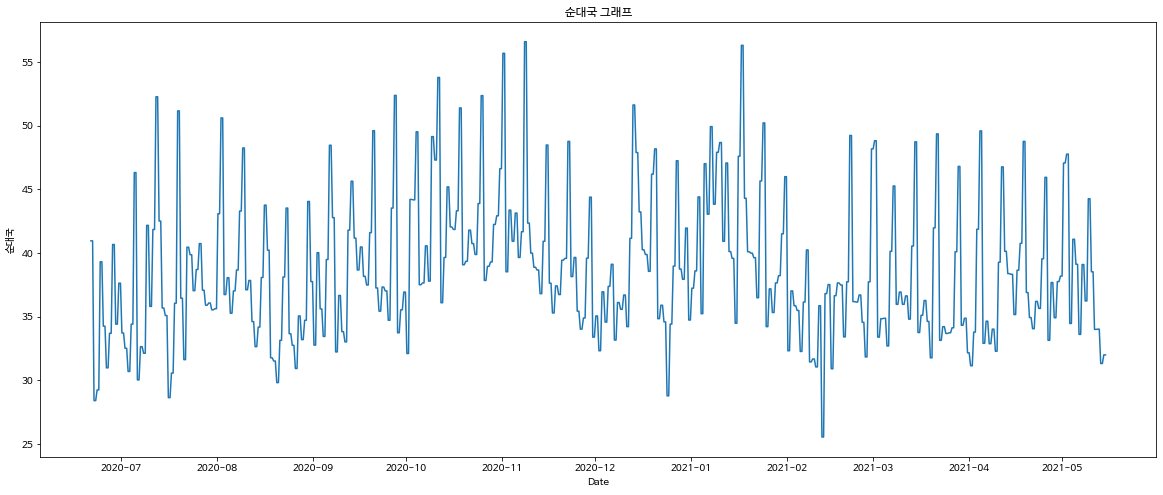

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


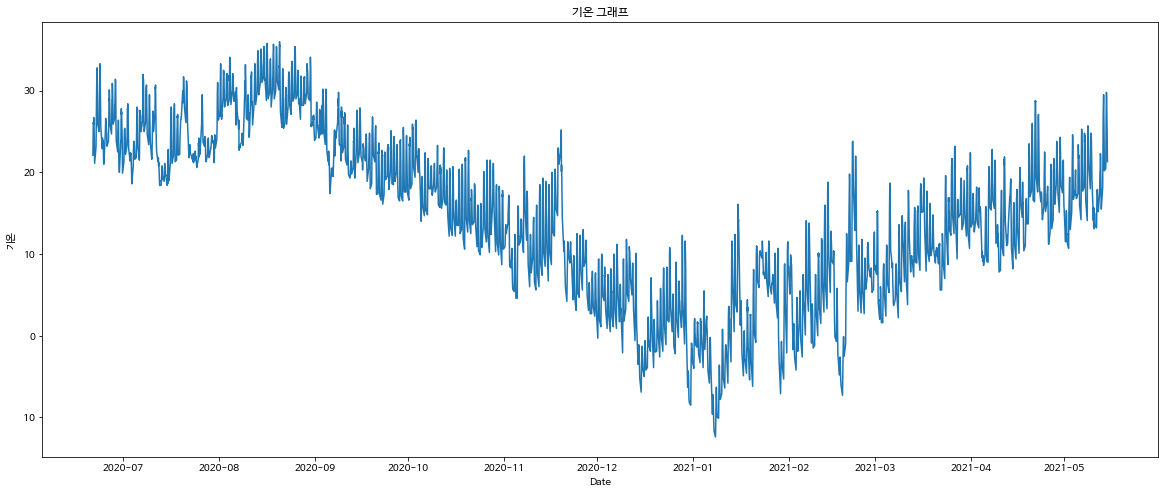

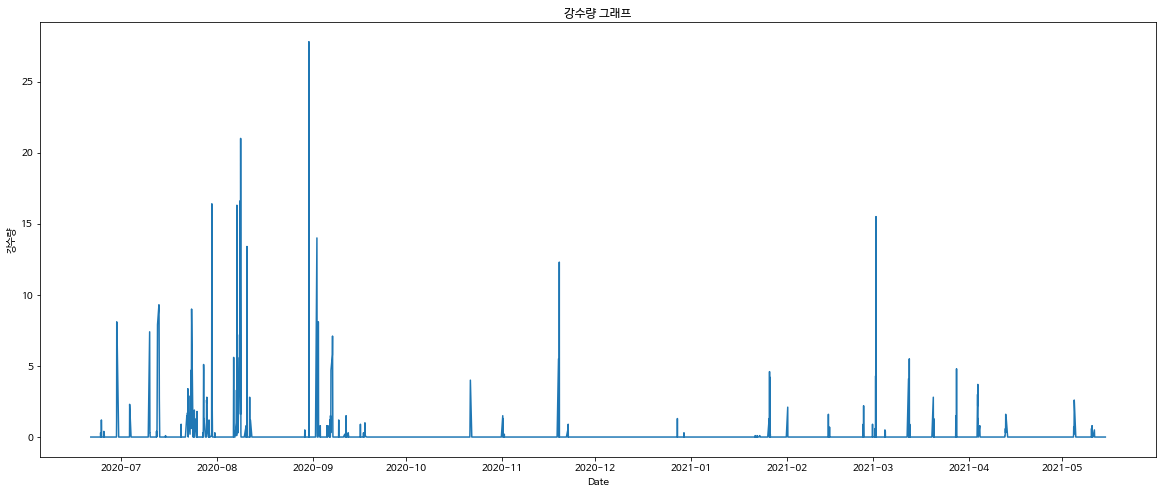

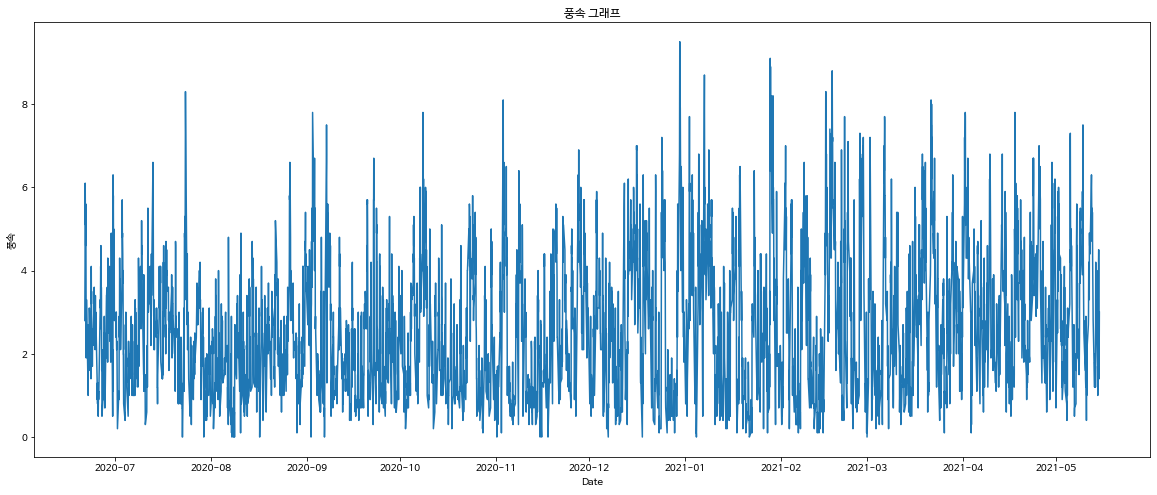

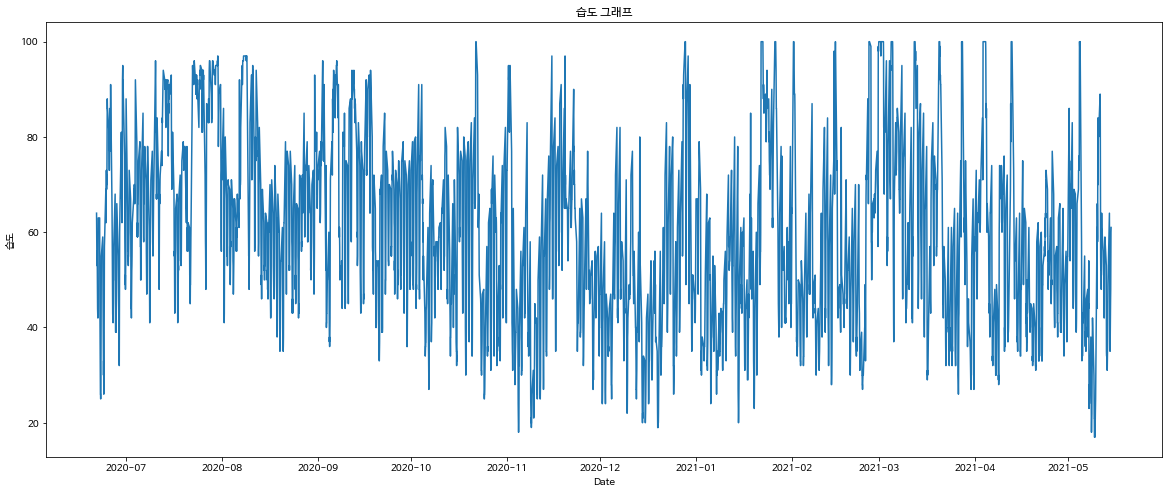

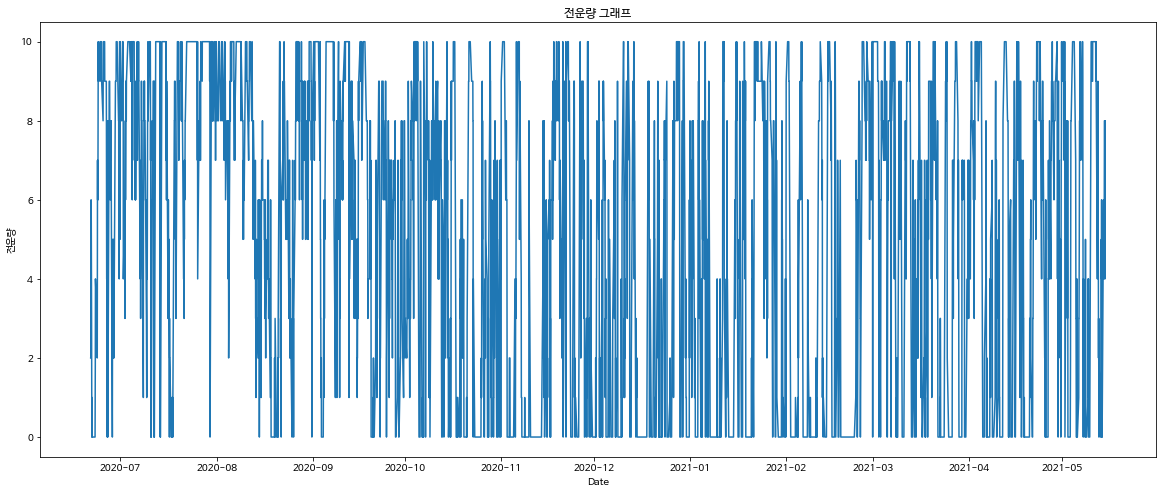

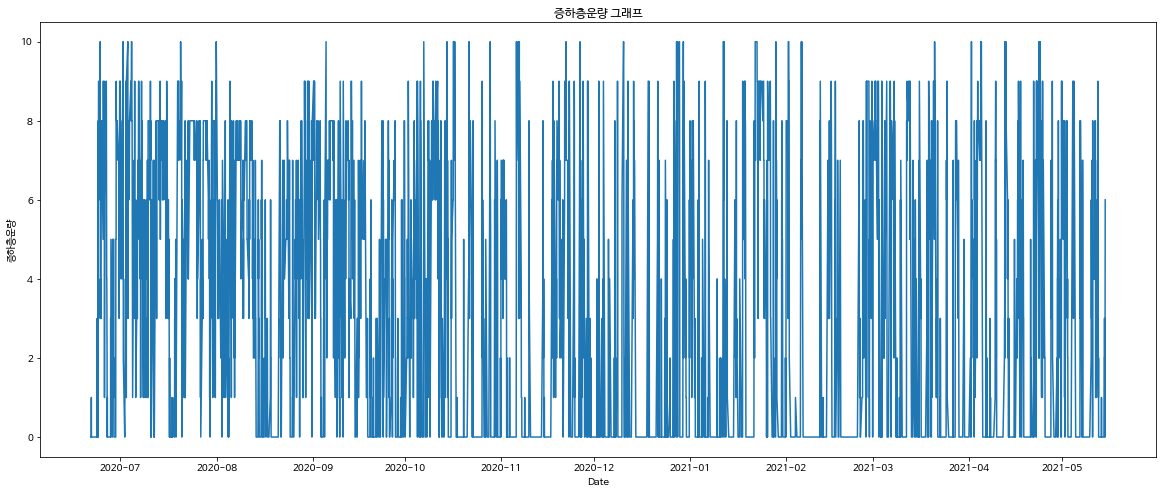

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


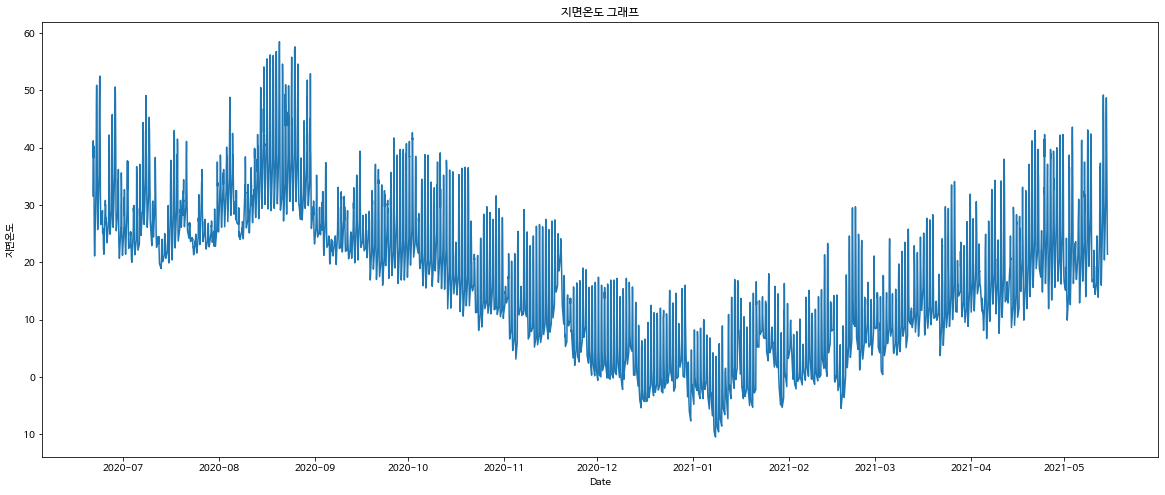

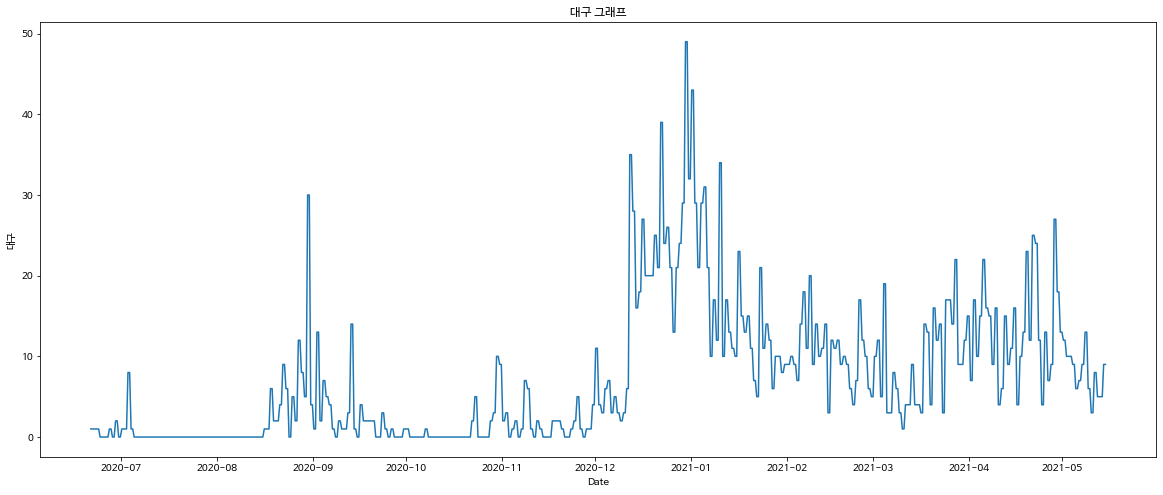

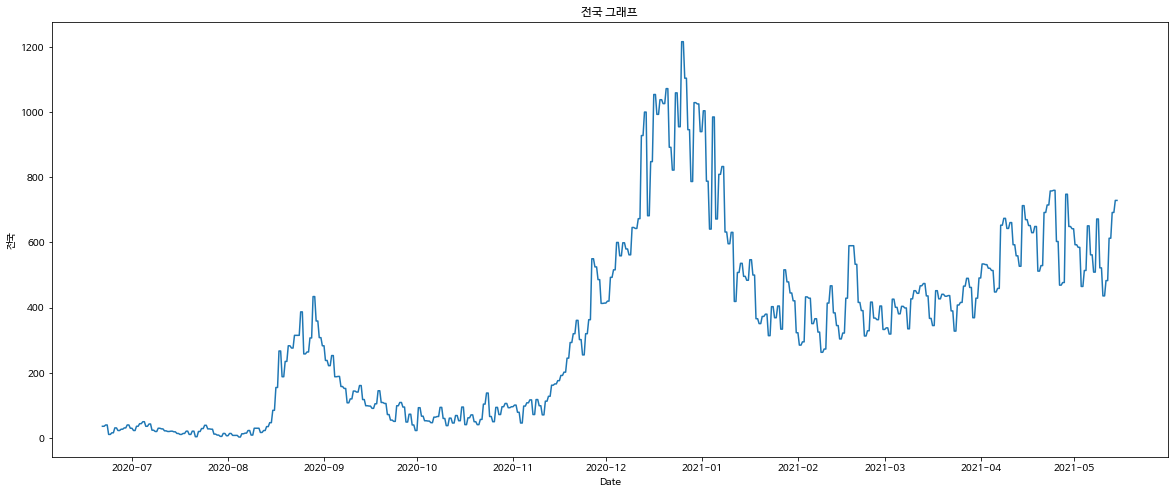

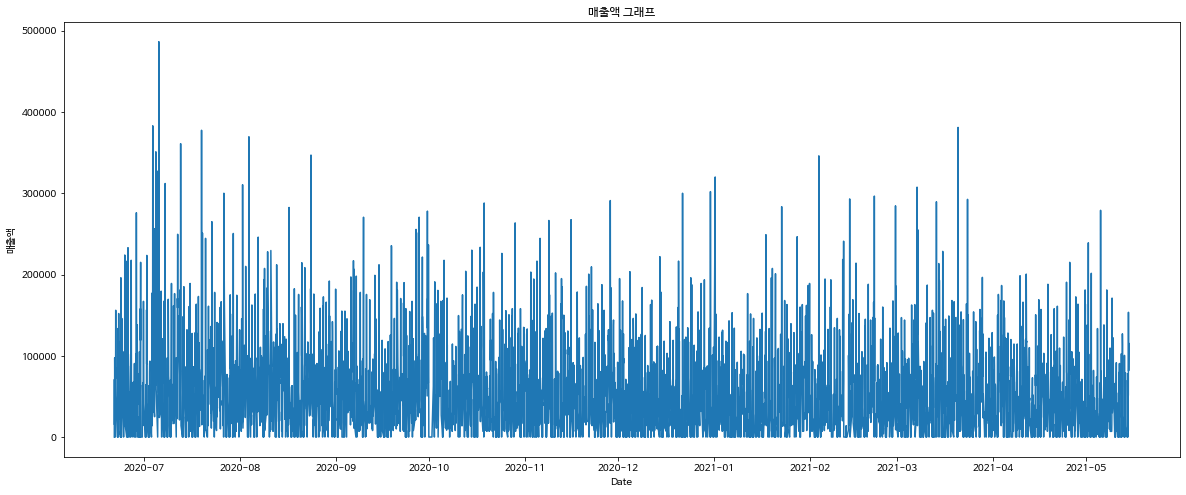

In [ ]:
for i,column in enumerate(df.columns.tolist()):
  plt.figure(figsize=(20,8))
  plt.title("{} 그래프".format(column))
  plt.plot(date_time,df[[column]])
  plt.xlabel("Date")
  plt.ylabel(column)
  plt.show()

In [ ]:
columns_indices = {name:i for i, name in enumerate(df.columns)}

n=len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
columns_indices

{'09시': 7,
 '10시': 8,
 '11시': 9,
 '12시': 10,
 '13시': 11,
 '14시': 12,
 '15시': 13,
 '16시': 14,
 '17시': 15,
 '18시': 16,
 '19시': 17,
 '20시': 18,
 '21시': 19,
 '22시': 20,
 '24절기': 22,
 '강수량': 27,
 '공휴일': 21,
 '금': 4,
 '기온': 26,
 '대구': 33,
 '돼지국밥': 24,
 '매출액': 35,
 '목': 3,
 '수': 2,
 '순대국': 25,
 '습도': 29,
 '월': 0,
 '일': 6,
 '잡절': 23,
 '전국': 34,
 '전운량': 30,
 '증하층운량': 31,
 '지면온도': 32,
 '토': 5,
 '풍속': 28,
 '화': 1}

In [ ]:
df[columns_indices.keys()]

월  화  수  목  금  토  일 09시  ...   풍속  습도 전운량 증하층운량  지면온도 대구   전국     매출액
0     0  0  0  0  0  0  1   1  ...  2.8  64   2     0  31.6  1   36       0
1     0  0  0  0  0  0  1   0  ...  3.4  59   2     0  36.3  1   36   71000
2     0  0  0  0  0  0  1   0  ...  4.1  53   3     0  41.2  1   36   15000
3     0  0  0  0  0  0  1   0  ...  6.1  53   6     0  40.5  1   36   97500
4     0  0  0  0  0  0  1   0  ...  5.5  54   6     0  38.2  1   36   44000
...  .. .. .. .. .. .. ..  ..  ...  ...  ..  ..   ...   ... ..  ...     ...
4587  0  0  0  0  1  0  0   0  ...  4.1  46   8     2  30.2  9  729   52000
4588  0  0  0  0  1  0  0   0  ...  3.1  48   6     0  26.4  9  729  153500
4589  0  0  0  0  1  0  0   0  ...  1.4  55   4     0  23.5  9  729   81500
4590  0  0  0  0  1  0  0   0  ...  2.0  60   8     4  22.4  9  729   83000
4591  0  0  0  0  1  0  0   0  ...  3.0  61   7     6  21.4  9  729  115000

[4592 rows x 36 columns]

In [ ]:
date_time

0      2020-06-21 09:00:00
1      2020-06-21 10:00:00
2      2020-06-21 11:00:00
3      2020-06-21 12:00:00
4      2020-06-21 13:00:00
               ...        
4587   2021-05-14 18:00:00
4588   2021-05-14 19:00:00
4589   2021-05-14 20:00:00
4590   2021-05-14 21:00:00
4591   2021-05-14 22:00:00
Name: 날짜, Length: 4592, dtype: datetime64[ns]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


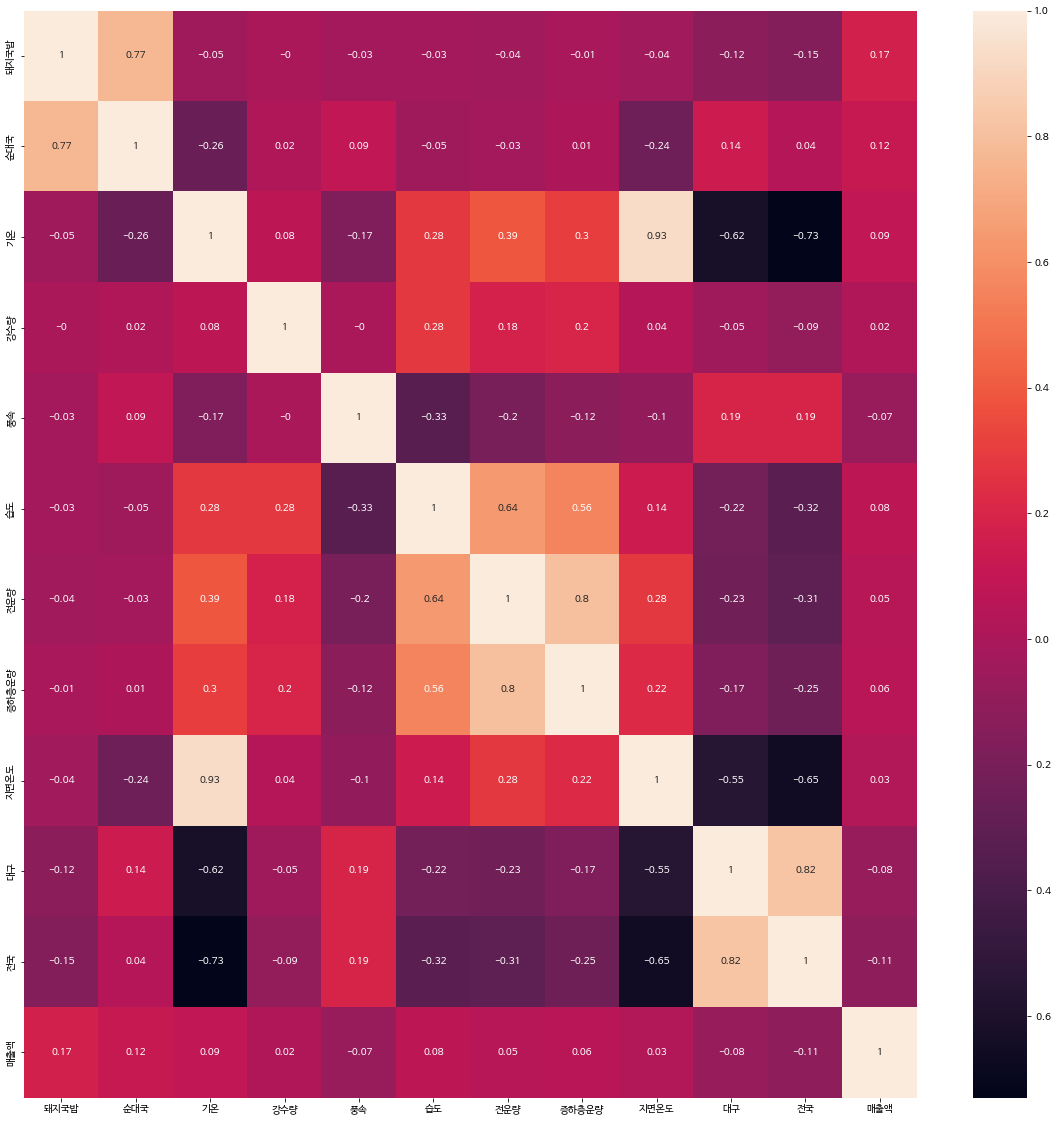

In [ ]:
train_corr = train_df.corr()

plt.figure(figsize=(20,20))
sns.heatmap(train_corr.round(2), annot=True, annot_kws={"size":10})

In [ ]:
train_df.columns.tolist().index('22시')

20

In [ ]:
print("공휴일 매출 평균 : ",train_df[train_df['공휴일']==1]['매출액'].mean())
print("평상시 매출 평균 : ",train_df[train_df['공휴일']==0]['매출액'].mean())

공휴일 매출 평균 :  61385.71428571428
평상시 매출 평균 :  58628.497072218604


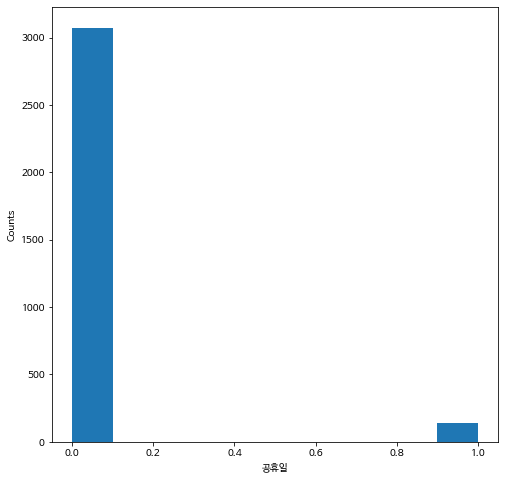

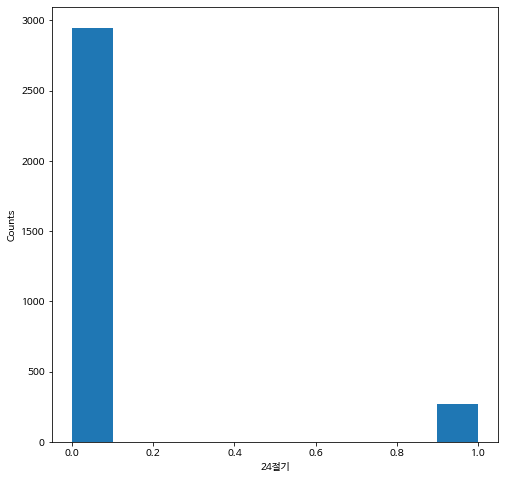

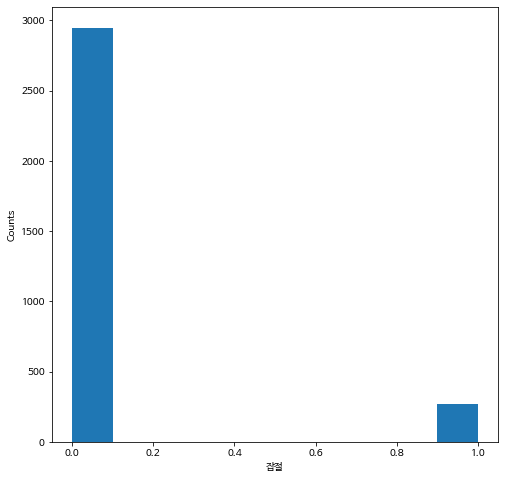

In [ ]:
for column in train_df.columns.tolist()[21:24]:
  plt.figure(figsize=(8,8))
  plt.xlabel(column)
  plt.ylabel('Counts')
  plt.hist(train_df[column])
  plt.show()

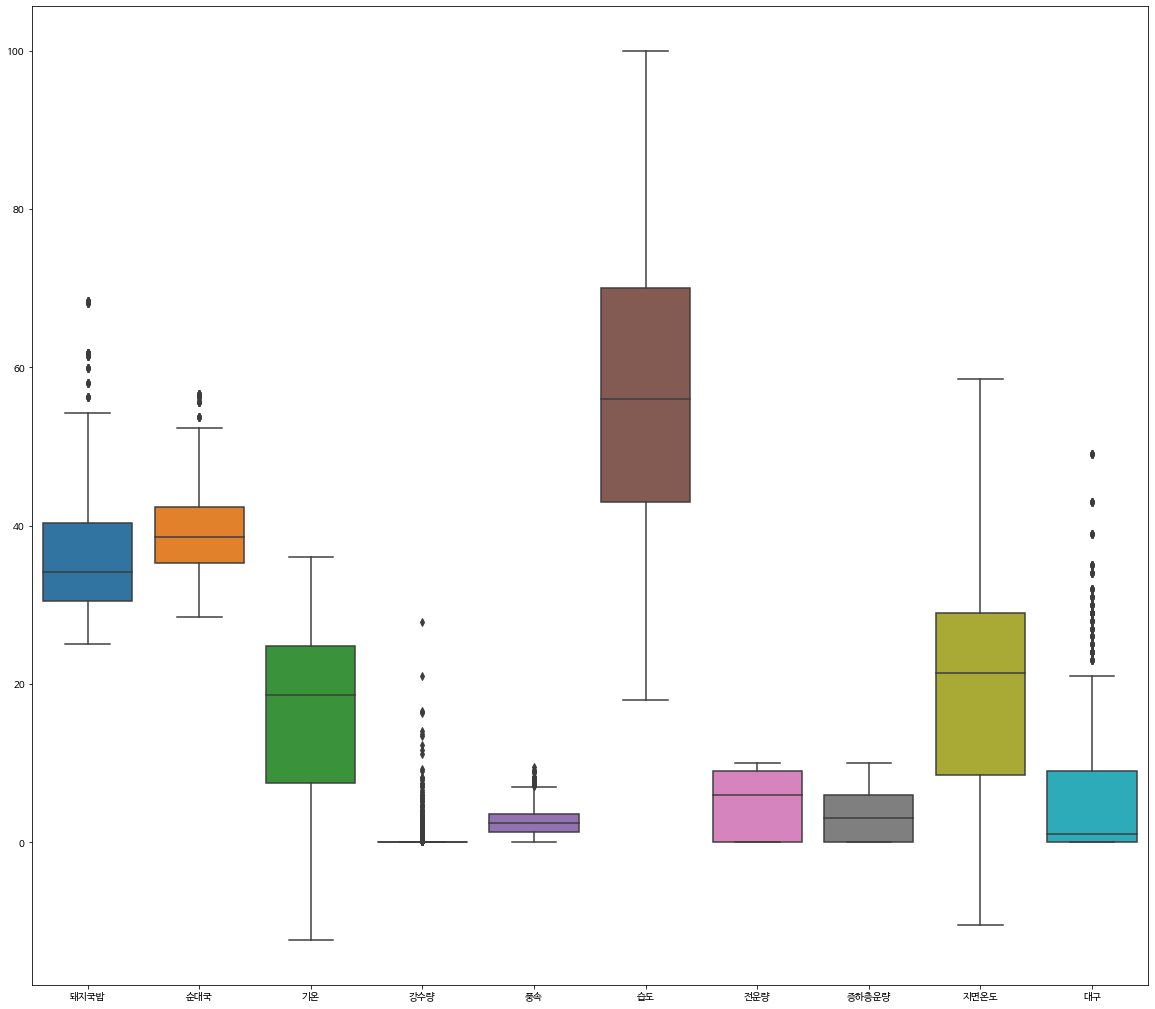

In [ ]:
sns.boxplot(data=train_df[train_df.columns.tolist()[24:-2]])
plt.show()

In [ ]:
df[df.columns.tolist()[-1]].mean()

56569.79529616725

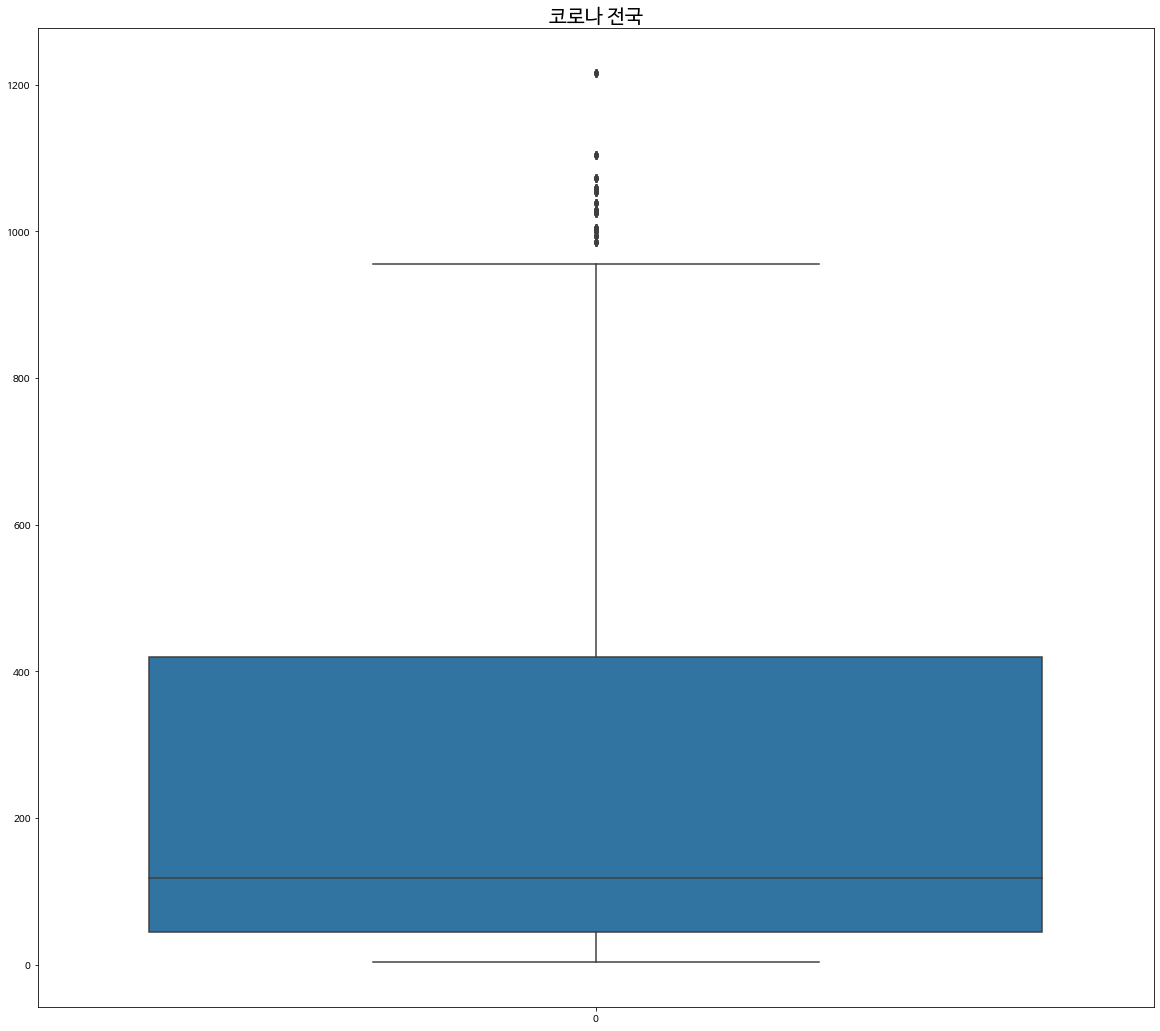

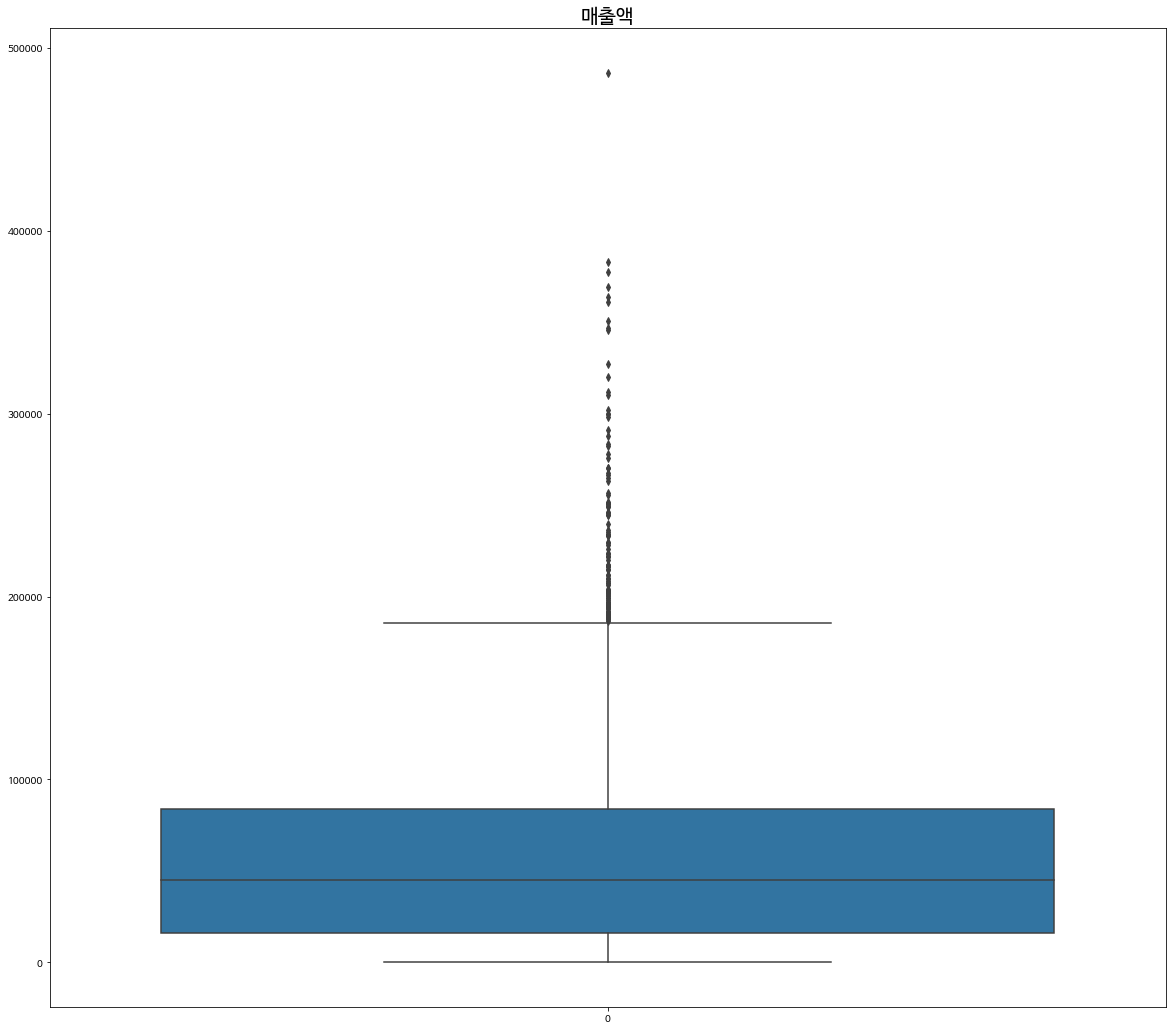

In [ ]:
plt.title("코로나 전국",{'fontsize':20})
sns.boxplot(data=train_df[train_df.columns.tolist()[-2]])
plt.show()
plt.title("매출액",{'fontsize':20})
sns.boxplot(data=train_df[train_df.columns.tolist()[-1]])
plt.show()

In [ ]:
### MinMax Scale

# train_max = train_df.max()
# train_sales_max = train_df.max()['매출액']
# train_min = train_df.min()
# train_sales_min = train_df.min()['매출액']

# train_df = (train_df - train_min)/(train_max - train_min)
# val_df = (val_df - train_min)/(train_max - train_min)
# test_df = (test_df - train_min)/(train_max - train_min)

#train_df=train_df.fillna(0)
#val_df=val_df.fillna(0)
#test_df=test_df.fillna(0)

train_df

월  화  수  목  금  토  일 09시  ...   풍속  습도 전운량 증하층운량  지면온도  대구   전국     매출액
0     0  0  0  0  0  0  1   1  ...  2.8  64   2     0  31.6   1   36       0
1     0  0  0  0  0  0  1   0  ...  3.4  59   2     0  36.3   1   36   71000
2     0  0  0  0  0  0  1   0  ...  4.1  53   3     0  41.2   1   36   15000
3     0  0  0  0  0  0  1   0  ...  6.1  53   6     0  40.5   1   36   97500
4     0  0  0  0  0  0  1   0  ...  5.5  54   6     0  38.2   1   36   44000
...  .. .. .. .. .. .. ..  ..  ...  ...  ..  ..   ...   ...  ..  ...     ...
3209  0  0  0  0  1  0  0   0  ...  1.2  50   8     0   2.0  14  351  107000
3210  0  0  0  0  1  0  0   0  ...  1.3  45   6     3   4.0  14  351   54000
3211  0  0  0  0  1  0  0   0  ...  1.3  40   9     7   5.1  14  351    8000
3212  0  0  0  0  1  0  0   0  ...  1.7  39   9     7   5.6  14  351    8000
3213  0  0  0  0  1  0  0   0  ...  1.2  38   9     7   5.7  14  351   61500

[3214 rows x 36 columns]

In [ ]:
train_stats_df = train_df[train_df.columns.tolist()[24:]].describe()
train_stats_df

돼지국밥          순대국  ...           전국            매출액
count  3214.000000  3214.000000  ...  3214.000000    3214.000000
mean     36.528164    39.314377  ...   272.645302   58748.599876
std       8.294379     5.643247  ...   299.561333   56653.069629
min      25.040210    28.400350  ...     3.000000       0.000000
25%      30.455760    35.281500  ...    44.000000   16000.000000
50%      34.119740    38.552270  ...   118.000000   45000.000000
75%      40.375330    42.341370  ...   419.000000   84000.000000
max      68.436100    56.586230  ...  1216.000000  486500.000000

[8 rows x 12 columns]

In [ ]:
#### 네이버 검색 빈도는 이미 데이터 자체가 0~100으로 상대적인 수치로 제공되어 스케일이 되어 있다고 생각이 되므로 스케일링 따로 진행 안함.

# 기온
temp_Q1 = train_stats_df.loc['25%']['기온']
temp_Q3 = train_stats_df.loc['75%']['기온']
temp_median = train_stats_df[['기온']].median()
temp_IQR = temp_Q3 - temp_Q1
temp_low = temp_median - 1.5*temp_IQR
temp_up = temp_median + 1.5*temp_IQR

# 풍속
wind_Q1 = train_stats_df.loc['25%']['풍속']
wind_Q3 = train_stats_df.loc['75%']['풍속']
wind_median = train_stats_df[['풍속']].median()
wind_IQR = wind_Q3 - wind_Q1
wind_low = wind_median - 1.5*wind_IQR
wind_up = wind_median + 1.5*wind_IQR

# 습도
humid_Q1 = train_stats_df.loc['25%']['습도']
humid_Q3 = train_stats_df.loc['75%']['습도']
humid_median = train_stats_df[['습도']].median()
humid_IQR = humid_Q3 - humid_Q1
humid_low = humid_median - 1.5*humid_IQR
humid_up = humid_median + 1.5*humid_IQR

# 지면온도
land_Q1 = train_stats_df.loc['25%']['지면온도']
land_Q3 = train_stats_df.loc['75%']['지면온도']
land_median = train_stats_df[['지면온도']].median()
land_IQR = land_Q3 - land_Q1
land_low = land_median - 1.5*land_IQR
land_up = land_median + 1.5*land_IQR

# 매출액
sales_Q1 = train_stats_df.loc['25%']['매출액']
sales_Q3 = train_stats_df.loc['75%']['매출액']
sales_median = train_stats_df[['매출액']].median()
sales_IQR = sales_Q3 - sales_Q1
sales_low = 0
sales_up = sales_median + 1.5*sales_IQR

In [ ]:
## MinMax 스케일링을 할 때, 각각의 피처가 모델에 어떻게 영향을 줄 것인지에 대해 고민을 하고 스케일링을 하자.
## -30과 30을 normalization하고, 매출액도 normaliztion 이 이루어져야 한다.
## 0과 1사이의 기온이 다르면 달라짐에 따라서 반비례 그래프가 일차함수로 나온다고 가정하면 기울기가 w, 매출이 0원부터 80만원까지이면 매출에 대한 가중치가 0.00001
## → 가중치를 직접 눈으로 확인 ; 제안 : LSTM을 사용하지 말고 가장 기본적인 모델을 사용할 것 (바닐라 RNN). 우리가 학습이 이루어지는 과정을 직접 눈으로 확인할 것. 모델에서 print하면 된다.


In [ ]:
### Z-score Normalization
train_mean = train_df.mean()
train_std = train_df.std()
train_sales_mean = train_df.mean()['매출액']
train_sales_std = train_df.std()['매출액']

train_df.loc[:,train_df.columns.tolist()[24:]] = (train_df.loc[:,train_df.columns.tolist()[24:]] - train_mean) / train_std
val_df.loc[:,val_df.columns.tolist()[24:]] = (val_df.loc[:,val_df.columns.tolist()[24:]] - train_mean) / train_std
test_df.loc[:,test_df.columns.tolist()[24:]] = (test_df.loc[:,test_df.columns.tolist()[24:]] - train_mean) / train_std

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [ ]:
#train_df['매출액'] = train_df['매출액'].map(lambda x: np.random.uniform(0.08,0.1) if x==0. else x)
#val_df['매출액'] = val_df['매출액'].map(lambda x: np.random.uniform(0.08,0.1) if x==0. else x)
#test_df['매출액'] = test_df['매출액'].map(lambda x: np.random.uniform(0.08,0.1) if x==0. else x)

## 기본적으로, distribution을 정하고 모델링하면 잘 따라간다. 그런데, LSTM, RNN은 distribution이 정해져있지 않아서 잘 따라가지 않을 것이다.
## 그래서, 그 차이를 잘 따라가게 하기 위해서, 분포를 만들어 임의 값을 부여했다.

In [ ]:
test_df

월  화  수  목  금  ...     증하층운량      지면온도        대구        전국       매출액
4132  1  0  0  0  0  ... -0.082509 -0.290481  0.976428  0.955913 -0.913430
4133  1  0  0  0  0  ...  2.046265 -0.230784  0.976428  0.955913  0.489848
4134  1  0  0  0  0  ... -0.386620 -0.357640  0.976428  0.955913  0.366289
4135  1  0  0  0  0  ...  0.829823 -0.387489  0.976428  0.955913 -0.542753
4136  1  0  0  0  0  ...  0.829823 -0.402413  0.976428  0.955913 -0.772219
...  .. .. .. .. ..  ...       ...       ...       ...       ...       ...
4587  0  0  0  0  1  ... -0.386620  0.784062  0.327808  1.523410 -0.119122
4588  0  0  0  0  1  ... -0.994841  0.500502  0.327808  1.523410  1.672485
4589  0  0  0  0  1  ... -0.994841  0.284101  0.327808  1.523410  0.401592
4590  0  0  0  0  1  ...  0.221601  0.202018  0.327808  1.523410  0.428069
4591  0  0  0  0  1  ...  0.829823  0.127397  0.327808  1.523410  0.992910

[460 rows x 36 columns]

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               train_sales_mean = train_sales_mean, train_sales_std = train_sales_std,
               label_columns=None):
    # Store the raw data
    self.train_df = train_df
    self.val_df = val_df
    self.test_df=test_df

    self.train_sales_mean = train_sales_mean
    self.train_sales_std = train_sales_std

    #Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name:i for i,name in
                           enumerate(train_df.columns)}

    #Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0,input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
                      f'Total window size: {self.total_window_size}',
                      f'Input indices: {self.input_indices}',
                      f'Label indices: {self.label_indices}',
                      f'Label column name(s): {self.label_columns}'
    ])

In [ ]:
## 9시부터 22시까지 14시간 ; 5일을 입력하려면 14 x 5 = 70

w1 = WindowGenerator(input_width=70, label_width=14, shift=14,
                     label_columns=['매출액'])

In [ ]:
w1

Total window size: 84
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
Label indices: [70 71 72 73 74 75 76 77 78 79 80 81 82 83]
Label column name(s): ['매출액']

In [ ]:
column_list = df.columns.tolist()
column_list[24:]

['돼지국밥',
 '순대국',
 '기온',
 '강수량',
 '풍속',
 '습도',
 '전운량',
 '증하층운량',
 '지면온도',
 '대구',
 '전국',
 '매출액']

In [ ]:
def plot(self, model=None, plot_col=['매출액','기온','전국'], max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(20, 18))
  plot_col_index = [self.column_indices[column] for column in plot_col] #self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))

  fig, axes = plt.subplots(3, len(plot_col))
  for n in range(max_n):
    for i, idx in enumerate(plot_col_index):
      axes[n,i].set_ylabel(f'{plot_col[i]} [normed]')
      axes[n,i].plot(self.input_indices, inputs[n, :, idx],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = idx

      if label_col_index is None:
        continue

      axes[n,i].scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        axes[n,i].scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        axes[n,i].legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [ ]:
def plot_sales(self, model=None, plot_col='매출액', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(20, 18))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))

  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
            label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot_sales = plot_sales

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  #inputs = features[:, self.input_slice, :max(columns_indices.values())]
  labels = features[:, self.labels_slice, :]
  
  if self.label_columns is not None:
    # labels '매출액'에 minmax scale 해제
    # labels = tf.stack(
    #     [(self.train_sales_max-self.train_sales_min)* labels[:, :, self.column_indices[name]] +self.train_sales_min for name in self.label_columns],
    #     axis=-1)
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
    
  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


In [ ]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[2:2+w1.total_window_size]),
                           np.array(train_df[3:3+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 84, 36)
Inputs shape: (3, 70, 36)
labels shape: (3, 14, 1)


In [ ]:
def make_dataset(self,data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)
  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
train_df.columns

Index(['월', '화', '수', '목', '금', '토', '일', '09시', '10시', '11시', '12시', '13시',
       '14시', '15시', '16시', '17시', '18시', '19시', '20시', '21시', '22시', '공휴일',
       '24절기', '잡절', '돼지국밥', '순대국', '기온', '강수량', '풍속', '습도', '전운량', '증하층운량',
       '지면온도', '대구', '전국', '매출액'],
      dtype='object')

In [ ]:
def inverse_trans(self,data):
  ## note
  
  label_col = self.column_indices.get('매출액')

  inverse_data = self.train_df.copy()
  inverse_data['매출액'] = inverse_data.apply(lambda x: x['매출액'] * (self.train_sales_max - self.train_sales_min) + self.train_sales_min,
                                             axis=1)

  return inverse_data

WindowGenerator.inverse_trans = inverse_trans

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def inverseTrain(self):
  return self.make_dataset(self.inverse_trans(self.train_df))

@property
def inverseVal(self):
  return self.make_dataset(self.inverse_trans(self.val_df))

@property
def inverseTest(self):
  return self.make_dataset(self.inverse_trans(self.test_df))

@property
def example(self):
  """Get and cache an example batch of 'inputs, labels' for plotting."""
  result = getattr(self, '_example',None)
  if result is None:
    result = next(iter(self.train))
    self._example=result
  return result

@property
def inverseExample(self):
  """Get and cache an 'inverse' example batch of 'inputs, labels' for plotting."""
  result = getattr(self, '_inverse_example',None)
  if result is None:
    result = next(iter(self.inverseTrain))
    self._inverse_example=result
  return result

WindowGenerator.train=train
WindowGenerator.val=val
WindowGenerator.test=test
WindowGenerator.inverseTrain=inverseTrain
WindowGenerator.inverseVal=inverseVal
WindowGenerator.inverseTest=inverseTest
WindowGenerator.inverseExample=inverseExample
WindowGenerator.example=example

In [ ]:
w1.train.element_spec

(TensorSpec(shape=(None, 70, 36), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 14, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in w1.train.take(2):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 70, 36)
Labels shape (batch, time, features): (32, 14, 1)
Inputs shape (batch, time, features): (32, 70, 36)
Labels shape (batch, time, features): (32, 14, 1)


# compile_and_fit 실행

In [ ]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.RootMeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# multi step model

Total window size: 84
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
Label indices: [70 71 72 73 74 75 76 77 78 79 80 81 82 83]
Label column name(s): None

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<Figure size 1440x1296 with 0 Axes>

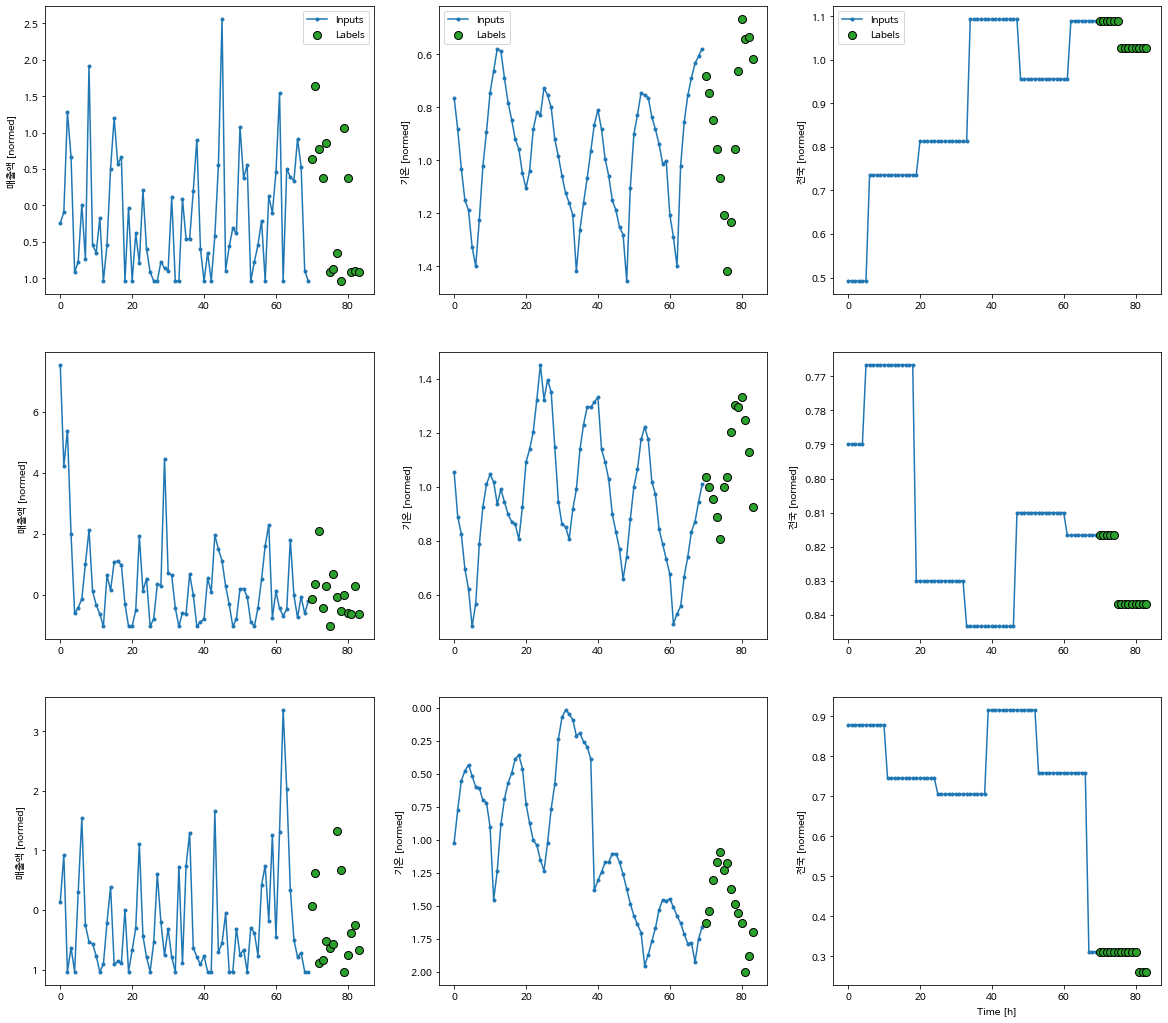

In [ ]:
## multi step model start

OUT_STEPS = 14
multi_window = WindowGenerator(input_width=70,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

## 회귀분석에서 확장된 것을 오토 리그레션이라고 한다. 그러니까, 동일하게 상관관계를 보면 된다.
## 오토 리그레션의 정의대로, 모델의 정의를 잘 이해하면 된다.
## 랜덤 프로세스는 시간에 따라 변하는 것
## 강수량과 이 시간적 그래프의 모델이 어떤 영향이 있는지를 연구하며 모델링.
## 오토 리그레시브로 모델링을 하면 2가지를 고려해야 한다.

## 여기서 지금까지 한 것에 대한 고민을 하여 다음주에 수정을 해올 것. plot을 눈으로 봐서, 매출과 가장 비슷한 그래프를 찾아보아라. 반비례던, 정비례던. 데이터의 피처들 중에서.

multi_window.plot()
multi_window

In [ ]:
multi_window.train

<MapDataset shapes: ((None, 70, 36), (None, 14, 36)), types: (tf.float32, tf.float32)>

In [ ]:
multi_window.val

<MapDataset shapes: ((None, 70, 36), (None, 14, 36)), types: (tf.float32, tf.float32)>

# 다중출력 모델

In [ ]:
## 다중 출력

class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=256, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs) # 참고 : https://m.blog.naver.com/jodi999/221428140456

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 36])

In [ ]:
def call(self, inputs, training=None):
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute on lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1,0,2])
  return predictions

FeedBack.call =call

In [ ]:
print('Output shape (batch, time, features):', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features): (32, 14, 36)


27/27 [==============================] - 2s 81ms/step - loss: 0.2441 - root_mean_squared_error: 0.4941


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


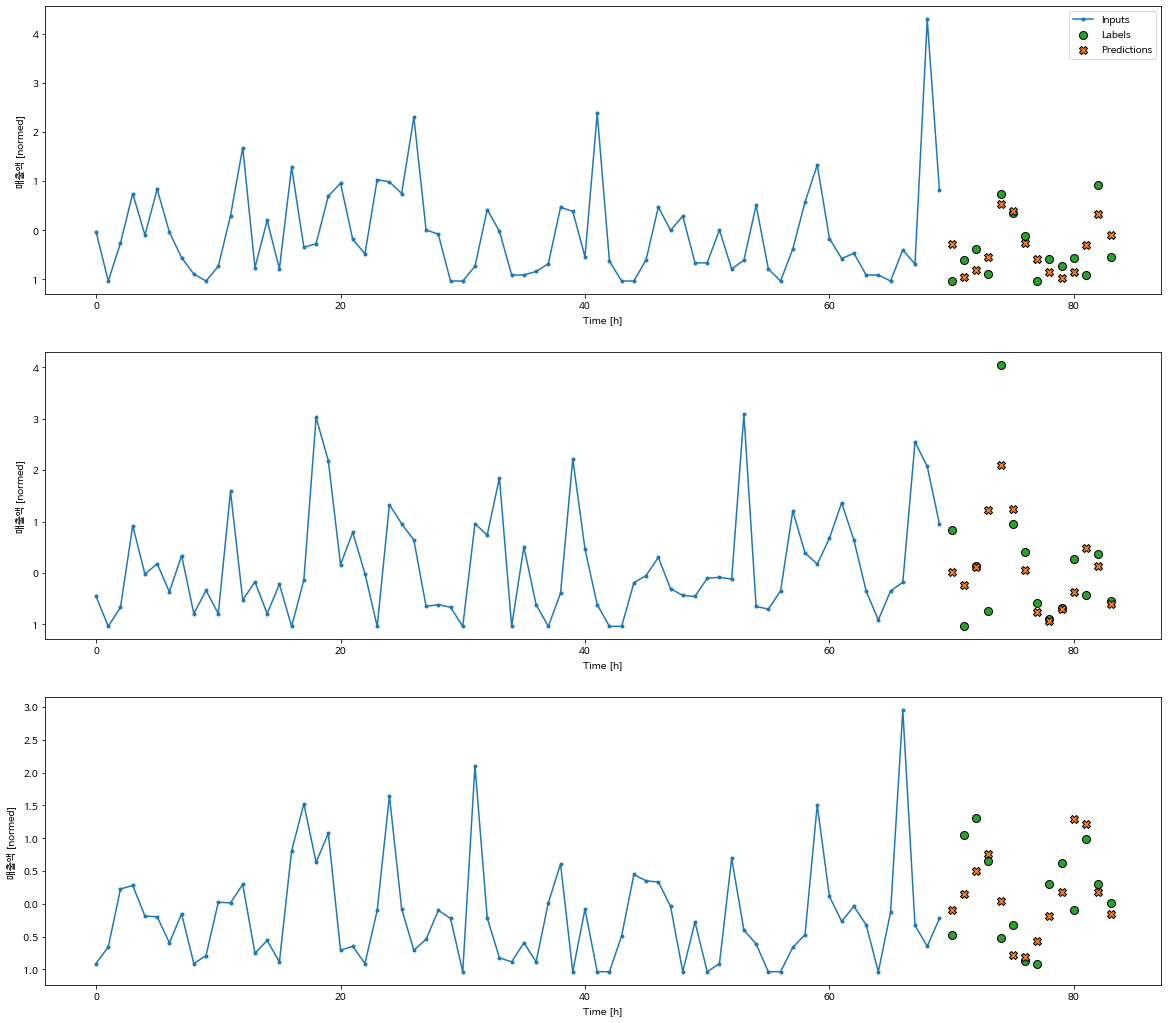

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot_sales(feedback_model)

# 멀티스텝 모델

27/27 [==============================] - 0s 4ms/step - loss: 0.3769 - mean_squared_error: 0.3769


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<Figure size 1440x1296 with 0 Axes>

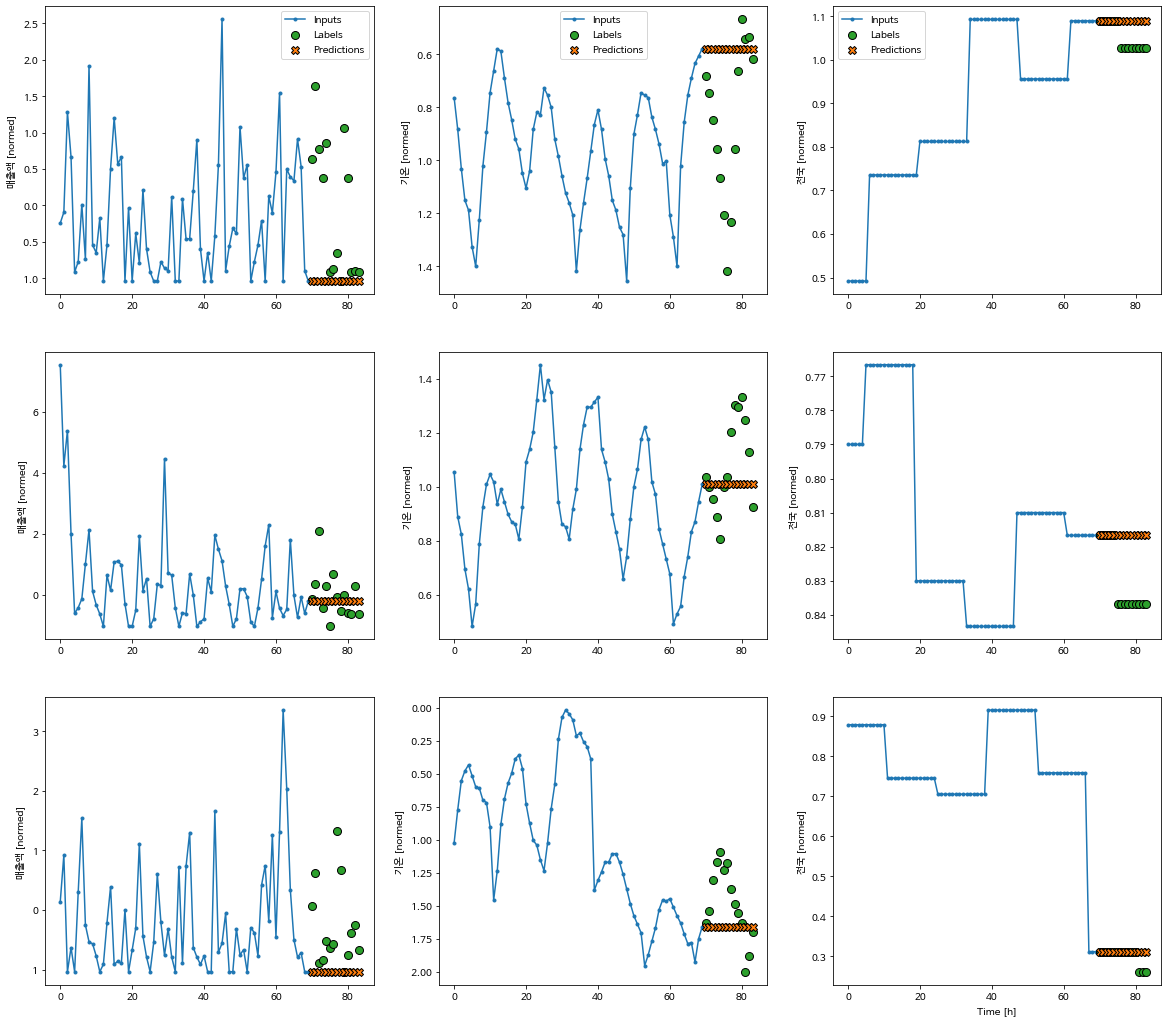

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    # print("*"*200)
    # print("tf.tile(inputs[:,-1:,:],[1,OUT_STEPS,1]):",tf.tile(inputs[:,-1:,:],[1,OUT_STEPS,1])) 
    # print("*"*200)
    return tf.tile(inputs[:,-1:,:],[1,OUT_STEPS,1]) # (batch, time, features) 에서 [1, OUT_STEPS, 1]의 의미는 1*OUT_STPES만큼만 inputs[:,-1,:](매출액)에 대한 데이터를 추출. shape = (32:batch,14:time_seq,36:features)
                                                    # [2, OUT_STEPS, 2]로 추출하니 shape = (64, 14, 72)로 데이터가 추출됨

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanSquaredError()])

multi_val_performance = {}
multi_performance = {}

IPython.display.clear_output()

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)
multi_window.plot(last_baseline)

Epoch 1/200
98/98 [==============================] - 5s 35ms/step - loss: 0.2727 - root_mean_squared_error: 0.5222 - val_loss: 0.2401 - val_root_mean_squared_error: 0.4900
Epoch 2/200
98/98 [==============================] - 3s 33ms/step - loss: 0.2010 - root_mean_squared_error: 0.4483 - val_loss: 0.2087 - val_root_mean_squared_error: 0.4569
Epoch 3/200
98/98 [==============================] - 3s 33ms/step - loss: 0.1820 - root_mean_squared_error: 0.4266 - val_loss: 0.2003 - val_root_mean_squared_error: 0.4476
Epoch 4/200
98/98 [==============================] - 3s 33ms/step - loss: 0.1736 - root_mean_squared_error: 0.4167 - val_loss: 0.1922 - val_root_mean_squared_error: 0.4384
Epoch 5/200
98/98 [==============================] - 3s 33ms/step - loss: 0.1681 - root_mean_squared_error: 0.4099 - val_loss: 0.1932 - val_root_mean_squared_error: 0.4395
Epoch 6/200
98/98 [==============================] - 3s 32ms/step - loss: 0.1630 - root_mean_squared_error: 0.4037 - val_loss: 0.1903 - val_

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


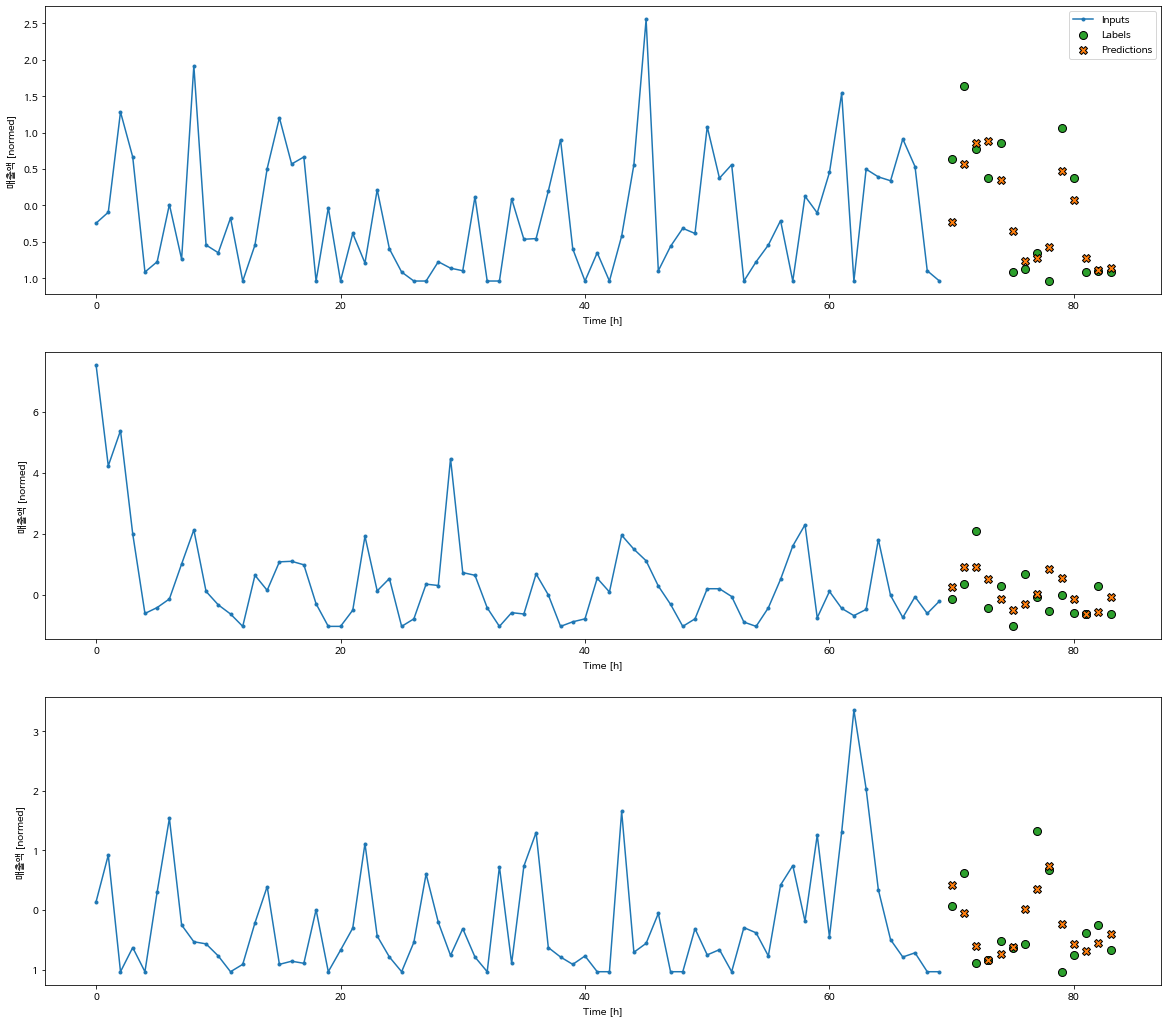

In [ ]:
## RNN

multi_rnn_model = tf.keras.Sequential([
            ## [batch, #units]
            tf.keras.layers.SimpleRNN(128),
            tf.keras.layers.Dense(OUT_STEPS*num_features, activation=tf.keras.activations.tanh),
            tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_rnn_model, multi_window)

multi_val_performance['RNN'] = multi_rnn_model.evaluate(multi_window.val)
multi_performance['RNN'] = multi_rnn_model.evaluate(multi_window.test, verbose=0)
multi_window.plot_sales(multi_rnn_model)

In [ ]:
weights = multi_rnn_model.get_weights()  # 가중치 출력 참고 : https://codetorial.net/tensorflow/get_weights.html

In [ ]:
multi_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               21120     
_________________________________________________________________
dense (Dense)                (None, 504)               65016     
_________________________________________________________________
reshape (Reshape)            (None, 14, 36)            0         
Total params: 86,136
Trainable params: 86,136
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(weights[0].shape)
print(weights[1].shape)
print(weights[2].shape)
print(weights[3].shape)
print(weights[4].shape)

(36, 128)
(128, 128)
(128,)
(128, 504)
(504,)


In [ ]:
print(multi_val_performance['RNN'])
print(multi_performance['RNN'])

[0.19661885499954224, 0.4434172213077545]
[0.19895607233047485, 0.4460449516773224]


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


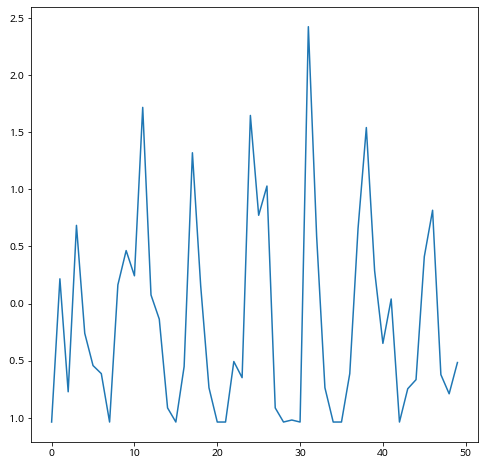

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(range(50),train_df.iloc[:50]['매출액'])

In [ ]:
noise_train_df = train_df.copy()
noise_val_df = val_df.copy()
noise_test_df = test_df.copy()
noise_train_df.head()

월  화  수  목  금  토  ...       전운량     증하층운량      지면온도        대구        전국       매출액
0  0  0  0  0  0  0  ... -0.806961 -0.994841  0.888532 -0.537019 -0.789973 -1.036989
1  0  0  0  0  0  0  ... -0.806961 -0.994841  1.239251 -0.537019 -0.789973  0.216253
2  0  0  0  0  0  0  ... -0.550095 -0.994841  1.604894 -0.537019 -0.789973 -0.772219
3  0  0  0  0  0  0  ...  0.220502 -0.994841  1.552659 -0.537019 -0.789973  0.684012
4  0  0  0  0  0  0  ...  0.220502 -0.994841  1.381031 -0.537019 -0.789973 -0.260332

[5 rows x 36 columns]

In [ ]:
## noise generate
train_noise = np.random.normal(0,1,len(noise_train_df))
val_noise = np.random.normal(0,1,len(noise_val_df))
test_noise = np.random.normal(0,1,len(noise_test_df))
print(len(train_noise))

3214


In [ ]:
## sales data add to noise
noise_train_df['매출액'] = noise_train_df['매출액'] + train_noise
noise_train_df.head()

월  화  수  목  금  토  ...       전운량     증하층운량      지면온도        대구        전국       매출액
0  0  0  0  0  0  0  ... -0.806961 -0.994841  0.888532 -0.537019 -0.789973 -0.840339
1  0  0  0  0  0  0  ... -0.806961 -0.994841  1.239251 -0.537019 -0.789973  1.994278
2  0  0  0  0  0  0  ... -0.550095 -0.994841  1.604894 -0.537019 -0.789973  0.798673
3  0  0  0  0  0  0  ...  0.220502 -0.994841  1.552659 -0.537019 -0.789973 -1.565090
4  0  0  0  0  0  0  ...  0.220502 -0.994841  1.381031 -0.537019 -0.789973 -0.832339

[5 rows x 36 columns]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


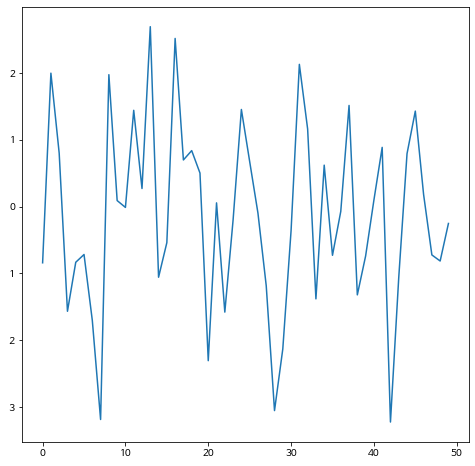

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(range(50),noise_train_df.iloc[:50]['매출액'])

In [ ]:
test_window = WindowGenerator(input_width=70,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=noise_train_df,
                              val_df=noise_val_df, test_df=noise_test_df)
test_window

Total window size: 84
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
Label indices: [70 71 72 73 74 75 76 77 78 79 80 81 82 83]
Label column name(s): None

In [ ]:
prediction = multi_rnn_model.predict(test_window.train)
prediction[-1].shape

(14, 36)

In [ ]:
prediction.shape

(3131, 14, 36)

In [ ]:
input_data = noise_train_df.iloc[3130:3200].to_numpy()
input_data3D = input_data.reshape(1,input_data.shape[0],input_data.shape[1])
label_data = noise_train_df.iloc[3200:3214]['매출액'].to_numpy()
label_data2D = label_data.reshape(label_data.shape[0],1)

print(input_data3D.shape)
print(label_data2D.shape)

(1, 70, 36)
(14, 1)


In [ ]:
prediction = multi_rnn_model.predict(input_data3D)[:,:,-1]
prediction = np.transpose(prediction,[1,0])
prediction

array([[-0.50729203],
       [-0.02805752],
       [ 0.6772133 ],
       [ 0.6082592 ],
       [-0.23371017],
       [-0.6146473 ],
       [-0.79605955],
       [-0.7359912 ],
       [-0.3992362 ],
       [ 0.57355696],
       [ 0.129311  ],
       [-0.6382986 ],
       [-0.77459717],
       [-0.66724443]], dtype=float32)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


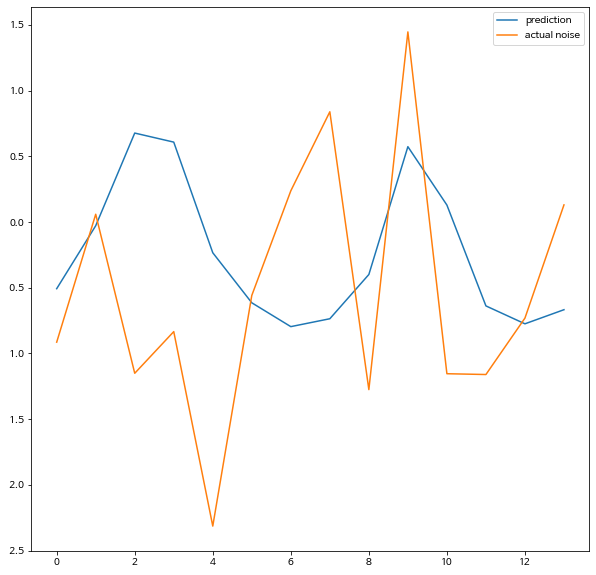

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(range(14),prediction,label="prediction")
plt.plot(range(14),label_data2D,label="actual noise")
plt.legend()
plt.show()

# 다양한 모델 구현

46/46 [==============================] - 0s 5ms/step - loss: 0.0101 - root_mean_squared_error: 0.1003


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50529 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50529 missing from current font.
  font.set_text

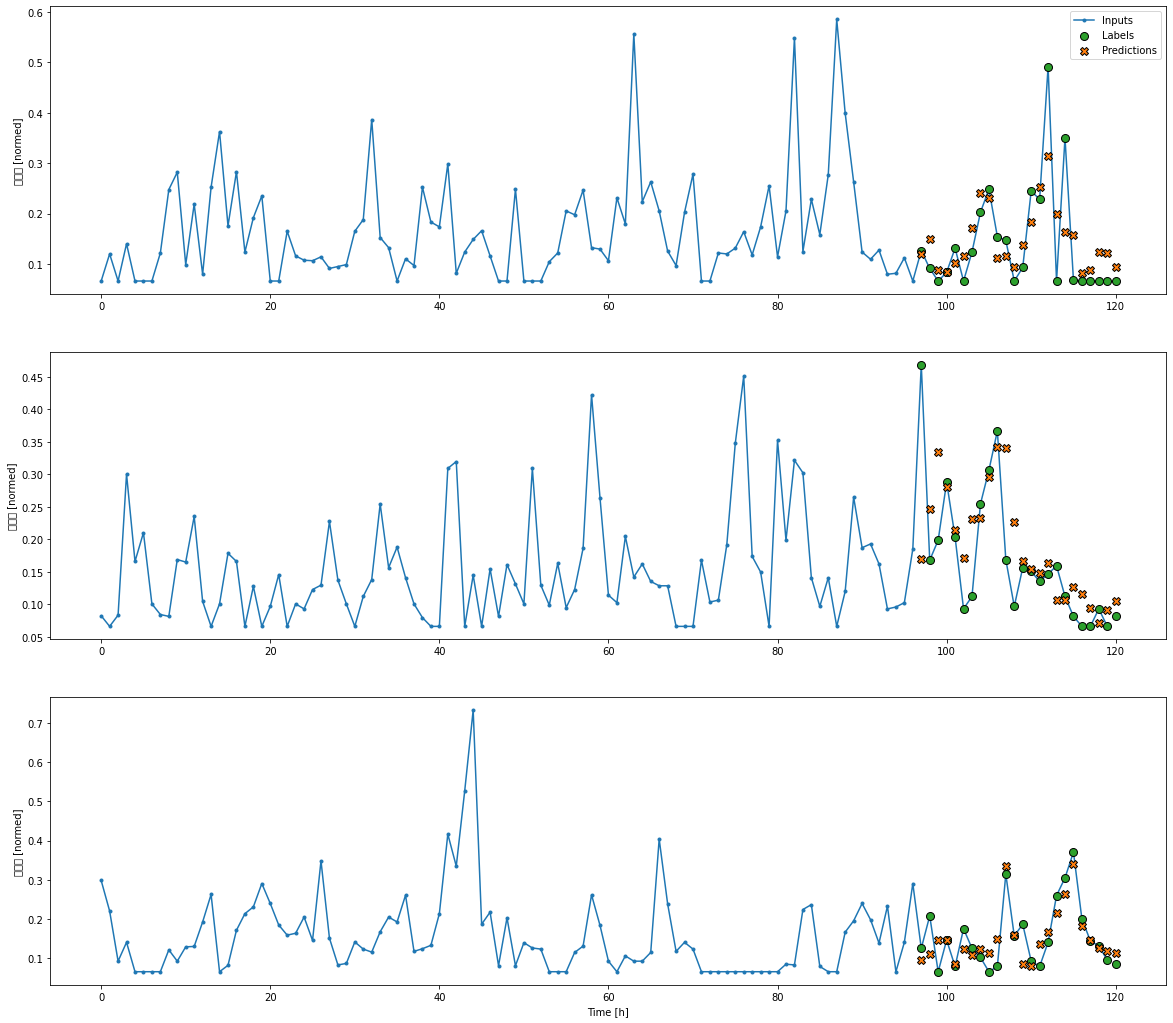

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.he_normal),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])           
])

## checkpoint

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test,verbose=0)
multi_window.plot(multi_conv_model)

In [ ]:
multi_val_performance['Conv']

[0.010055944323539734, 0.1002793237566948]

46/46 [==============================] - 5s 113ms/step - loss: 0.0035 - root_mean_squared_error: 0.0594


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50529 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50529 missing from current font.
  font.set_text

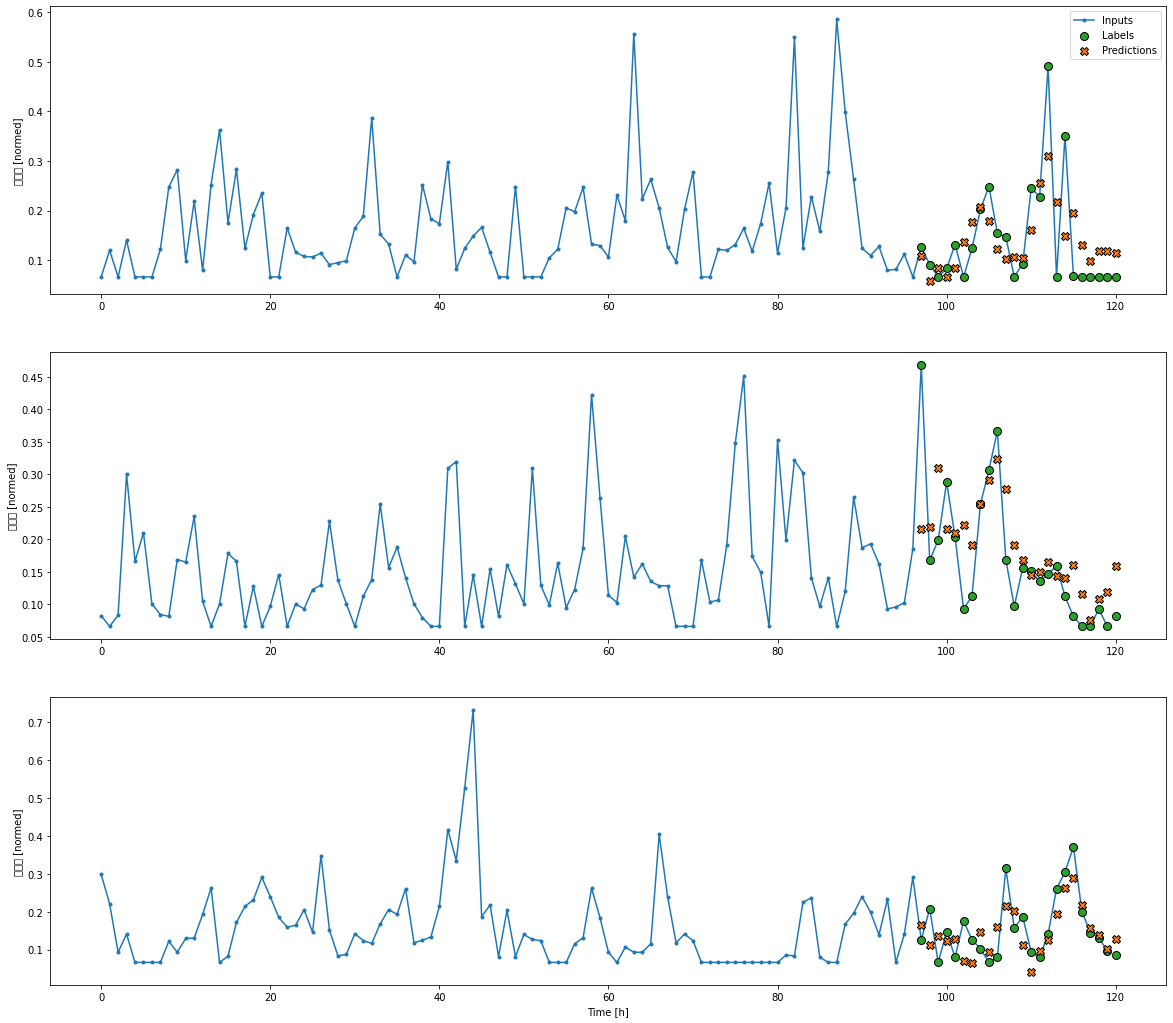

In [ ]:
##LSTM

multi_lstm_model = tf.keras.Sequential([
      # Shape [batch, time, features] => [batch, lstm_units]
      # Adding more 'lstm_units' just overfits more quickly.
      tf.keras.layers.LSTM(256, return_sequences=False),
      # Shape => [batch, out_steps*features]
      tf.keras.layers.Dense(OUT_STEPS*num_features, activation=tf.keras.layers.LeakyReLU(alpha=0.01),
                            kernel_initializer=tf.initializers.he_normal),
      # Shape => [batch, out_steps, features]
      tf.keras.layers.Reshape([OUT_STEPS, num_features]),
      tf.keras.layers.LSTM(128, return_sequences=False),
      # Shape => [batch, out_steps*features]
      tf.keras.layers.Dense(OUT_STEPS*num_features, activation=tf.keras.layers.LeakyReLU(alpha=0.01),
                            kernel_initializer=tf.initializers.he_normal),
      #tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.01),
      #                      kernel_initializer=tf.initializers.he_normal),
      # Shape => [batch, out_steps, features]
      tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

46/46 [==============================] - 1s 15ms/step - loss: 0.0031 - root_mean_squared_error: 0.0558


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50529 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50529 missing from current font.
  font.set_text

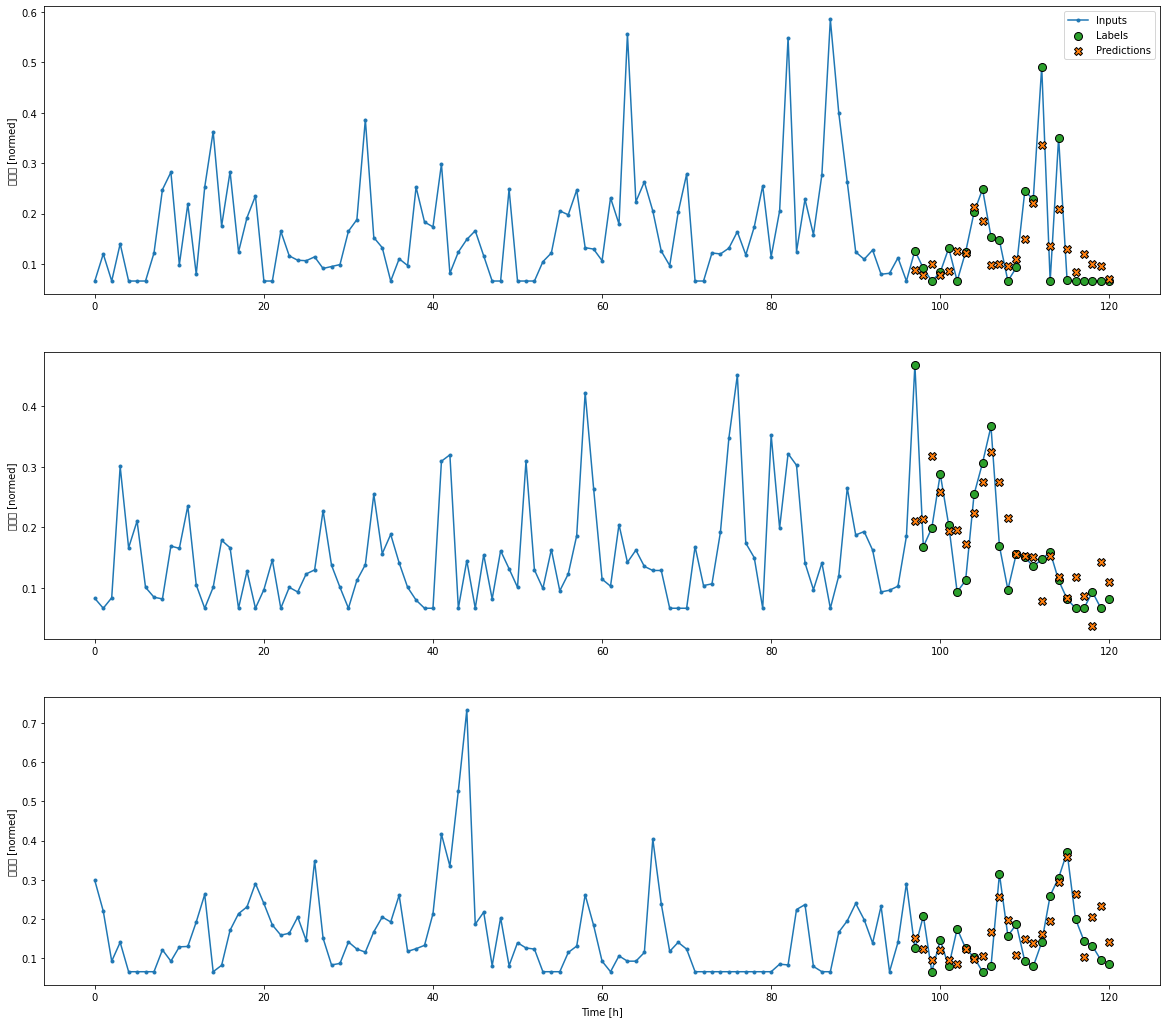

In [ ]:
multi_rnn_model = tf.keras.Sequential([
            tf.keras.layers.SimpleRNN(128, return_sequences=False),
            tf.keras.layers.Dense(OUT_STEPS*num_features, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
            tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_rnn_model, multi_window)

IPython.display.clear_output()

multi_val_performance['RNN'] = multi_rnn_model.evaluate(multi_window.val)
multi_performance['RNN'] = multi_rnn_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_rnn_model)

In [ ]:
multi_lstm_model.predict(multi_window.test).shape

(668, 24, 46)

In [ ]:
# for batch in multi_window.inverseTest:
#   inputs, labels = batch
#   print(inputs)

In [ ]:
multi_val_performance['LSTM']

[0.0035288457293063402, 0.059404075145721436]

In [ ]:
test_file = pd.read_csv(r'/content/sample_data/용산_test_21-05-15~21-05-31.csv')
test_file.drop(['Unnamed: 0'],axis=1,inplace=True)
date_test_file = pd.to_datetime(test_file.pop('날짜'), format='%Y-%m-%d %H:%M:%S')
comp_res = test_file.loc[360:]
test_file = test_file.loc[:359]
test_file

00시  01시  02시  03시  04시  05시  06시  ...  22시  23시    기온  강수량  습도  지면온도       매출액
0      1    0    0    0    0    0    0  ...    0    0  19.8  0.0  68  20.5       0.0
1      0    1    0    0    0    0    0  ...    0    0  19.3  0.0  71  20.2       0.0
2      0    0    1    0    0    0    0  ...    0    0  18.8  0.0  74  20.0       0.0
3      0    0    0    1    0    0    0  ...    0    0  18.4  0.0  77  19.4       0.0
4      0    0    0    0    1    0    0  ...    0    0  18.3  0.0  76  19.6       0.0
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...  ..   ...       ...
355    0    0    0    0    0    0    0  ...    0    0  22.5  0.0  41  21.4   46000.0
356    0    0    0    0    0    0    0  ...    0    0  22.2  0.0  43  20.0  105000.0
357    0    0    0    0    0    0    0  ...    0    0  21.5  0.0  50  19.2   33500.0
358    0    0    0    0    0    0    0  ...    1    0  19.5  0.0  59  18.1   70000.0
359    0    0    0    0    0    0    0  ...    0    1  19.0  0.0  56  16.8       0.0

[360 rows x 29 columns]

In [ ]:
input_rows = 120
features = 29

input_test = np.array(test_file)
input_test

array([[1.00e+00, 0.00e+00, 0.00e+00, ..., 6.80e+01, 2.05e+01, 0.00e+00],
       [0.00e+00, 1.00e+00, 0.00e+00, ..., 7.10e+01, 2.02e+01, 0.00e+00],
       [0.00e+00, 0.00e+00, 1.00e+00, ..., 7.40e+01, 2.00e+01, 0.00e+00],
       ...,
       [0.00e+00, 0.00e+00, 0.00e+00, ..., 5.00e+01, 1.92e+01, 3.35e+04],
       [0.00e+00, 0.00e+00, 0.00e+00, ..., 5.90e+01, 1.81e+01, 7.00e+04],
       [0.00e+00, 0.00e+00, 0.00e+00, ..., 5.60e+01, 1.68e+01, 0.00e+00]])

In [ ]:
input_test_re = input_test.reshape(-1, input_rows, features)

res = multi_lstm_model.predict(input_test_re)
res[-1,:,-1]

array([ 0.83435875,  0.35286662,  0.64788777,  0.19737507,  0.87178993,
        0.33018565,  0.3773466 ,  0.47175288,  0.3701803 ,  0.24452305,
       -0.00275807,  0.7494807 ,  0.50964206,  0.14615607,  0.7445732 ,
       -0.00377326, -0.00452825,  0.2877092 , -0.0016927 ,  0.12193456,
        0.3879508 ,  0.3186696 ,  0.78864676,  0.3637487 ], dtype=float32)

In [ ]:
pred_res = res[-1,:,-1]
pred_res

array([ 0.83435875,  0.35286662,  0.64788777,  0.19737507,  0.87178993,
        0.33018565,  0.3773466 ,  0.47175288,  0.3701803 ,  0.24452305,
       -0.00275807,  0.7494807 ,  0.50964206,  0.14615607,  0.7445732 ,
       -0.00377326, -0.00452825,  0.2877092 , -0.0016927 ,  0.12193456,
        0.3879508 ,  0.3186696 ,  0.78864676,  0.3637487 ], dtype=float32)

In [ ]:
inverse_pred = pred_res*(train_sales_max - train_sales_min) + train_sales_min
inverse_pred

array([400200.9  , 149343.52 , 303049.53 ,  68332.414, 419702.56 ,
       137526.72 , 162097.58 , 211283.25 , 158363.94 ,  92896.51 ,
       -35936.953, 355979.47 , 231023.53 ,  41647.312, 353422.62 ,
       -36465.867, -36859.22 , 115396.5  , -35381.895,  29027.906,
       167622.38 , 131526.86 , 376384.97 , 155013.08 ], dtype=float32)

In [ ]:
real_res = np.array(comp_res.loc[360:360+23]['매출액'])
final_res = pd.DataFrame({'real':real_res,'inverse_pred':inverse_pred,'pred':pred_res})
final_res

real   inverse_pred      pred
0        0.0  400200.906250  0.834359
1        0.0  149343.515625  0.352867
2        0.0  303049.531250  0.647888
3        0.0   68332.414062  0.197375
4        0.0  419702.562500  0.871790
5        0.0  137526.718750  0.330186
6        0.0  162097.578125  0.377347
7        0.0  211283.250000  0.471753
8        0.0  158363.937500  0.370180
9    16000.0   92896.507812  0.244523
10   39500.0  -35936.953125 -0.002758
11   86000.0  355979.468750  0.749481
12   34500.0  231023.531250  0.509642
13   93000.0   41647.312500  0.146156
14   16500.0  353422.625000  0.744573
15   44500.0  -36465.867188 -0.003773
16   18000.0  -36859.218750 -0.004528
17   61500.0  115396.500000  0.287709
18   93000.0  -35381.894531 -0.001693
19  146500.0   29027.906250  0.121935
20   59000.0  167622.375000  0.387951
21   81500.0  131526.859375  0.318670
22   87000.0  376384.968750  0.788647
23       0.0  155013.078125  0.363749

46/46 [==============================] - 1s 21ms/step - loss: 0.0043 - root_mean_squared_error: 0.0654


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50529 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50529 missing from current font.
  font.set_text

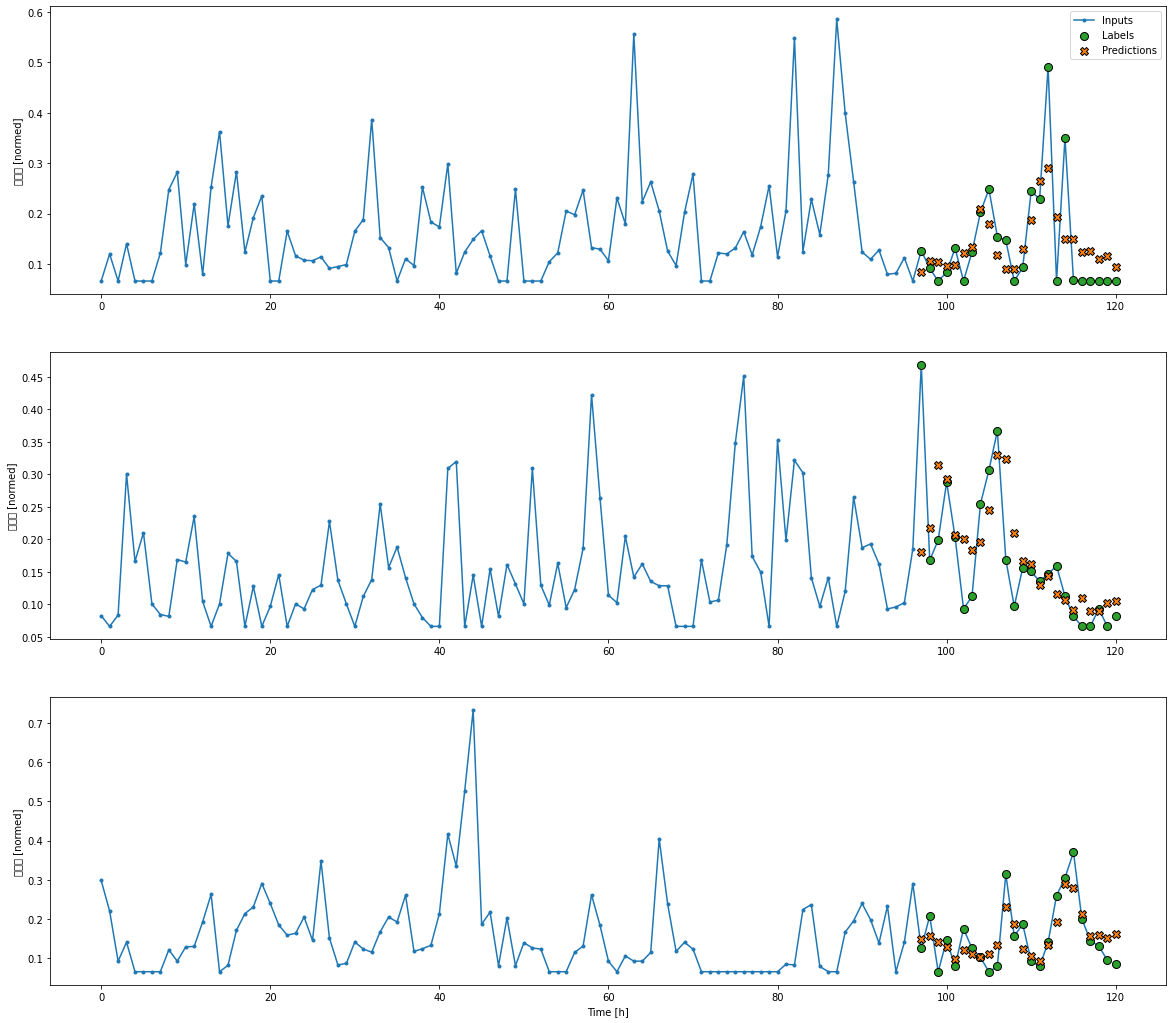

In [ ]:
# Bidirectional LSTM

multi_bilstm_model = tf.keras.Sequential([
      # Shape [batch, time, features] => [batch, lstm_units]
      # Adding more 'lstm_units' just overfits more quickly.
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
      # Shape => [batch, out_steps*features]
      tf.keras.layers.Dense(OUT_STEPS*num_features,
                            kernel_initializer=tf.initializers.he_normal),
      # Shape => [batch, out_steps, features]
      tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_bilstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['BiLSTM'] = multi_bilstm_model.evaluate(multi_window.val)
multi_performance['BiLSTM'] = multi_bilstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_bilstm_model)

46/46 [==============================] - 0s 6ms/step - loss: 0.0126 - root_mean_squared_error: 0.1124


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50529 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50529 missing from current font.
  font.set_text

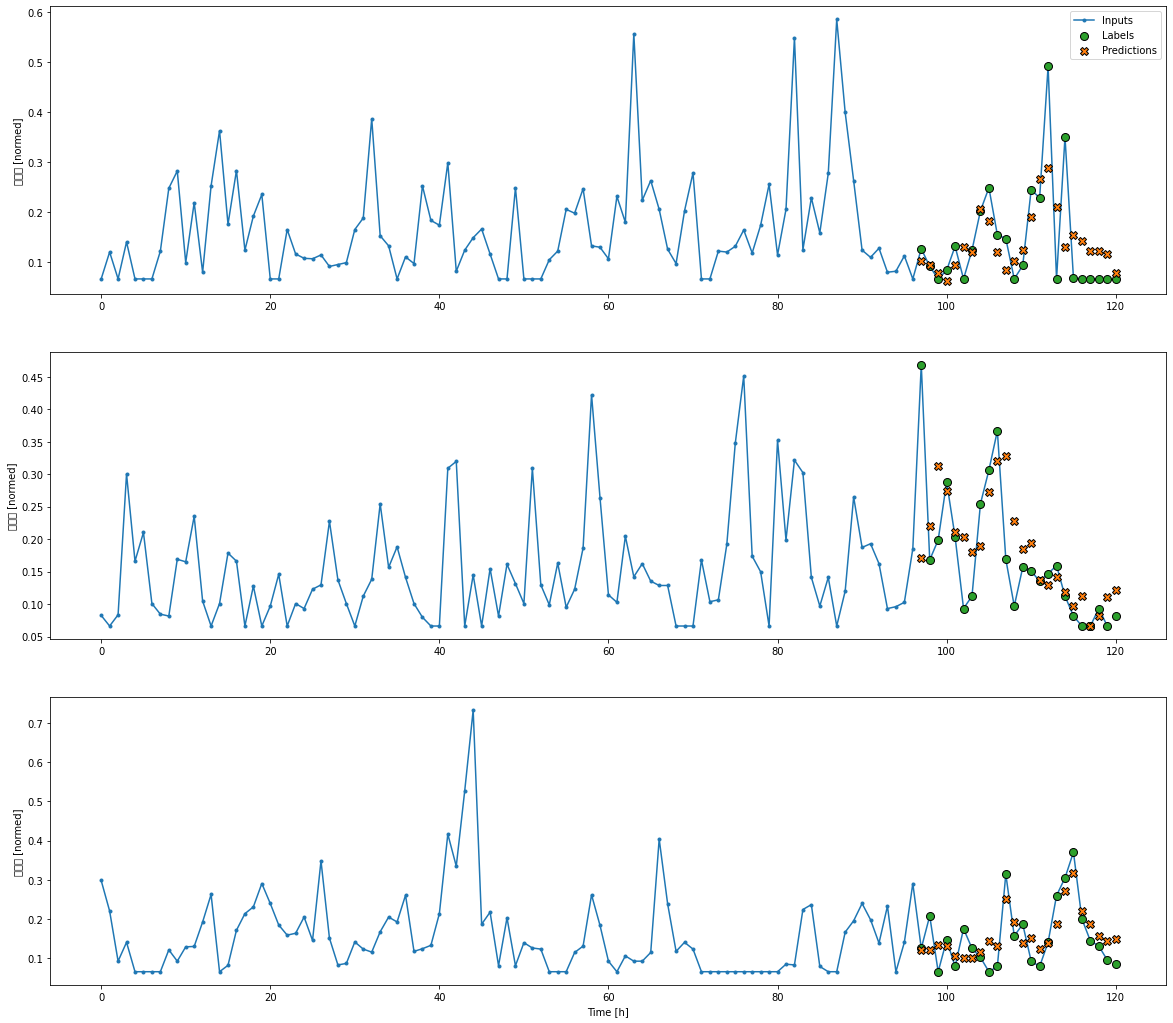

In [ ]:
# Conv-LSTM model

# https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

CONV_WIDTH = 3

multi_conv_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.he_normal),
    # Adding more 'lstm_units' just overfits more quickly.
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.he_normal),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv_LSTM'] = multi_conv_lstm_model.evaluate(multi_window.val)
multi_performance['Conv_LSTM'] = multi_conv_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_lstm_model)

In [ ]:
print("Conv loss:",multi_val_performance['Conv'])
print("LSTM loss:",multi_val_performance['LSTM'])
print("Bi LSTM loss:",multi_val_performance['BiLSTM'])
print("Conv LSTM loss:",multi_val_performance['Conv_LSTM'])
print("RNN loss:",multi_val_performance['RNN'])

Conv loss: [0.010055944323539734, 0.1002793237566948]
LSTM loss: [0.0035288457293063402, 0.059404075145721436]
Bi LSTM loss: [0.0042821564711630344, 0.06543818861246109]
Conv LSTM loss: [0.012631770223379135, 0.1123911440372467]
RNN loss: [0.0031185036059468985, 0.05584355816245079]


In [ ]:
len(history.history['loss'])

23

# 생략

In [ ]:
actual_df = pd.read_csv(r'/content/sample_data/용산_모델학습데이터.csv')
try:
  actual_df.drop(['Unnamed: 0'],axis=1,inplace=True)
except:
  pass

actual_df = actual_df[7086:7878]

actual_date_time = pd.to_datetime(actual_df.pop('날짜'), format='%Y-%m-%d %H:%M:%S')

apply_df = (actual_df - train_min)/(train_max - train_min)

apply_df=apply_df.fillna(0)
apply_df

FileNotFoundError: ignored

In [ ]:
actual_date_time

NameError: ignored

In [ ]:
actual_timestamp_s = actual_date_time.map(datetime.datetime.timestamp)
actual_timestamp_s

In [ ]:
class ActualWindowGenerator():
  def __init__(self, input_width, label_width, shift,
               actual_df=actual_df,
               train_sales_max = train_sales_max, train_sales_min = train_sales_min,
               label_columns=None):
    # Store the raw data
    self.actual_df = actual_df

    self.train_sales_max = train_sales_max
    self.train_sales_min = train_sales_min

    #Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name:i for i,name in
                           enumerate(actual_df.columns)}

    #Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0,input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
                      f'Total window size: {self.total_window_size}',
                      f'Input indices: {self.input_indices}',
                      f'Label indices: {self.label_indices}',
                      f'Label column name(s): {self.label_columns}'
    ])

In [ ]:
def actualplot(self, model=None, plot_col='매출액', max_subplots=1):
  inputs, labels = self.actualExample
  print("inputs:",inputs)
  print("labels:",labels)
  plt.figure(figsize=(20, 18))
  plot_col_index = self.column_indices[plot_col]
  print("column_indices:",self.column_indices)
  print("plot_col_index:",plot_col_index)
  max_n = min(max_subplots, len(inputs))

  plt.subplot(1, 1, 1)
  plt.ylabel(f'{plot_col} [normed]')
  plt.plot(self.input_indices, inputs[0, :, plot_col_index],
            label='Inputs', marker='.', zorder=-10)

  if self.label_columns:
    label_col_index = self.label_columns_indices.get(plot_col, None)
  else:
    label_col_index = plot_col_index

  if label_col_index is None:
    pass
  else:
    plt.scatter(self.label_indices, labels[0, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      plt.scatter(self.label_indices, predictions[0, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

ActualWindowGenerator.actualplot = actualplot

In [ ]:
def actual_split_window(self, features):
  inputs = features[:, self.input_slice, :]
  #inputs = features[:, self.input_slice, :max(columns_indices.values())]
  labels = features[:, self.labels_slice, :]
  
  if self.label_columns is not None:
    # labels '매출액'에 minmax scale 해제
    # labels = tf.stack(
    #     [(self.train_sales_max-self.train_sales_min)* labels[:, :, self.column_indices[name]] +self.train_sales_min for name in self.label_columns],
    #     axis=-1)
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
    
  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

ActualWindowGenerator.actual_split_window = actual_split_window

In [ ]:
def actual_make_dataset(self,data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=1,)
  ds = ds.map(self.actual_split_window)

  return ds

ActualWindowGenerator.actual_make_dataset = actual_make_dataset

In [ ]:
def actual_inverse_trans(self,data):
  ## note
  
  label_col = self.column_indices.get('매출액')

  inverse_data = self.actual_df.copy()
  inverse_data['매출액'] = inverse_data.apply(lambda x: x['매출액'] * (self.train_sales_max - self.train_sales_min) + self.train_sales_min,
                                             axis=1)

  return inverse_data

ActualWindowGenerator.actual_inverse_trans = actual_inverse_trans

In [ ]:
@property
def actual(self):
  return self.actual_make_dataset(self.actual_df)

@property
def inverseActual(self):
  return self.actual_make_dataset(self.actual_inverse_trans(self.actual_df))
@property
def actualExample(self):
  """Get and cache an example batch of 'inputs, labels' for plotting."""
  result = getattr(self, '_example',None)
  if result is None:
    result = next(iter(self.actual))
    self._example=result
  return result

@property
def inverseActualExample(self):
  """Get and cache an 'inverse' example batch of 'inputs, labels' for plotting."""
  result = getattr(self, '_inverse_example',None)
  if result is None:
    result = next(iter(self.inverseActual))
    self._inverse_example=result
  return result

ActualWindowGenerator.actual=actual
ActualWindowGenerator.inverseActual=inverseActual
ActualWindowGenerator.actualExample=actualExample
ActualWindowGenerator.inverseActualExample=inverseActualExample

In [ ]:
multi_actual_window = ActualWindowGenerator(input_width=672,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_actual_window.actualplot()
multi_actual_window

In [ ]:
for batch in multi_actual_window.actual:
  inputs, label = batch
  print(inputs.shape)
  test_data = np.array(inputs)

test_data

In [ ]:
multi_lstm_model.predict(test_data).shape  # array를 넣어주면 예측 값을 반환해준다.

In [ ]:
history

# 생략

In [ ]:
##실제 데이터 반영해서 POS의 매출과 비교해보기

In [ ]:
actual_df2 = pd.read_csv(r'/content/sample_data/용산_모델학습데이터.csv')
try:
  actual_df2.drop(['Unnamed: 0'],axis=1,inplace=True)
except:
  pass

actual_df2 = actual_df2[7758:7878]

print(actual_df2)

actual_date_time2 = pd.to_datetime(actual_df2.pop('날짜'), format='%Y-%m-%d %H:%M:%S')

apply_df2 = (actual_df2 - train_min)/(train_max - train_min)

apply_df2=apply_df2.fillna(0)
apply_df2

                       날짜  월  화  수  목  ...  증하층운량  지면온도   대구     전국       매출액
7758  2021-05-10 00:00:00  1  0  0  0  ...      0  14.6  3.0  436.0       0.0
7759  2021-05-10 01:00:00  1  0  0  0  ...      0  13.9  3.0  436.0       0.0
7760  2021-05-10 02:00:00  1  0  0  0  ...      1  13.0  3.0  436.0       0.0
7761  2021-05-10 03:00:00  1  0  0  0  ...      0  12.3  3.0  436.0       0.0
7762  2021-05-10 04:00:00  1  0  0  0  ...      2  12.5  3.0  436.0       0.0
...                   ... .. .. .. ..  ...    ...   ...  ...    ...       ...
7873  2021-05-14 19:00:00  0  0  0  0  ...      0  26.4  9.0  729.0  153500.0
7874  2021-05-14 20:00:00  0  0  0  0  ...      0  23.5  9.0  729.0   81500.0
7875  2021-05-14 21:00:00  0  0  0  0  ...      4  22.4  9.0  729.0   83000.0
7876  2021-05-14 22:00:00  0  0  0  0  ...      6  21.4  9.0  729.0  115000.0
7877  2021-05-14 23:00:00  0  0  0  0  ...      8  21.0  9.0  729.0   51500.0

[120 rows x 47 columns]


월    화    수    목    금  ...  증하층운량      지면온도        대구        전국       매출액
7758  1.0  0.0  0.0  0.0  0.0  ...    0.0  0.375533  0.061224  0.356966  0.066219
7759  1.0  0.0  0.0  0.0  0.0  ...    0.0  0.365576  0.061224  0.356966  0.066219
7760  1.0  0.0  0.0  0.0  0.0  ...    0.1  0.352774  0.061224  0.356966  0.066219
7761  1.0  0.0  0.0  0.0  0.0  ...    0.0  0.342817  0.061224  0.356966  0.066219
7762  1.0  0.0  0.0  0.0  0.0  ...    0.2  0.345661  0.061224  0.356966  0.066219
...   ...  ...  ...  ...  ...  ...    ...       ...       ...       ...       ...
7873  0.0  0.0  0.0  0.0  1.0  ...    0.0  0.543385  0.183673  0.598516  0.360845
7874  0.0  0.0  0.0  0.0  1.0  ...    0.0  0.502134  0.183673  0.598516  0.222649
7875  0.0  0.0  0.0  0.0  1.0  ...    0.4  0.486486  0.183673  0.598516  0.225528
7876  0.0  0.0  0.0  0.0  1.0  ...    0.6  0.472262  0.183673  0.598516  0.286948
7877  0.0  0.0  0.0  0.0  1.0  ...    0.8  0.466572  0.183673  0.598516  0.165067

[120 rows x 46 columns]

In [ ]:
actual_date_time2

7758   2021-05-10 00:00:00
7759   2021-05-10 01:00:00
7760   2021-05-10 02:00:00
7761   2021-05-10 03:00:00
7762   2021-05-10 04:00:00
               ...        
7873   2021-05-14 19:00:00
7874   2021-05-14 20:00:00
7875   2021-05-14 21:00:00
7876   2021-05-14 22:00:00
7877   2021-05-14 23:00:00
Name: 날짜, Length: 120, dtype: datetime64[ns]

In [ ]:
actual_timestamp_s2 = actual_date_time2.map(datetime.datetime.timestamp)
actual_timestamp_s2

7758    1.620605e+09
7759    1.620608e+09
7760    1.620612e+09
7761    1.620616e+09
7762    1.620619e+09
            ...     
7873    1.621019e+09
7874    1.621022e+09
7875    1.621026e+09
7876    1.621030e+09
7877    1.621033e+09
Name: 날짜, Length: 120, dtype: float64

In [ ]:
dimen_2 = np.array(apply_df2)
dimen_3 = np.array(apply_df2).reshape(1,len(actual_df2.index),46)

In [ ]:
pred = multi_lstm_model.predict(dimen_3)
pred

array([[[-0.00279093, -0.00846781,  0.00845954, ...,  0.04468158,
          0.51238656,  0.21424258],
        [-0.00434977, -0.00371329, -0.00130317, ..., -0.00114185,
          0.41056737,  0.16141576],
        [-0.00702441, -0.00571097, -0.0011979 , ...,  0.01698067,
          0.3719445 ,  0.14210059],
        ...,
        [-0.01622229, -0.00449774, -0.00634454, ...,  0.09345696,
          0.4403858 ,  0.22714981],
        [-0.01223905, -0.00658399, -0.00358043, ...,  0.06703063,
          0.36687052,  0.1336104 ],
        [-0.0176583 , -0.00694163, -0.00561359, ...,  0.19384374,
          0.415445  ,  0.1485419 ]]], dtype=float32)

In [ ]:
pred.shape

(1, 24, 46)

In [ ]:
inverse_pred = pred * (train_sales_max - train_sales_min) + train_sales_min
inverse_pred

NameError: ignored

In [ ]:
data_col_dict = {name: i for i, name in enumerate(apply_df2.columns)}

inverse_pred[0,:,data_col_dict.get('매출액')]

array([ 77120.38  ,  49597.61  ,  39534.406 ,  59420.305 ,  18891.152 ,
        31039.422 ,  17174.39  ,   5451.6094,  27732.488 ,  73854.555 ,
        40505.703 ,  97213.92  , 100050.53  ,  81889.66  ,  31515.992 ,
        23678.934 ,  59208.562 ,  47749.383 ,  82821.77  , 174655.6   ,
       153922.5   ,  83845.055 ,  35111.016 ,  42890.33  ], dtype=float32)

In [ ]:
inverse_pred[0,:,data_col_dict.get('매출액')].reshape(-1,1)

array([[ 77120.38  ],
       [ 49597.61  ],
       [ 39534.406 ],
       [ 59420.305 ],
       [ 18891.152 ],
       [ 31039.422 ],
       [ 17174.39  ],
       [  5451.6094],
       [ 27732.488 ],
       [ 73854.555 ],
       [ 40505.703 ],
       [ 97213.92  ],
       [100050.53  ],
       [ 81889.66  ],
       [ 31515.992 ],
       [ 23678.934 ],
       [ 59208.562 ],
       [ 47749.383 ],
       [ 82821.77  ],
       [174655.6   ],
       [153922.5   ],
       [ 83845.055 ],
       [ 35111.016 ],
       [ 42890.33  ]], dtype=float32)

In [ ]:
# import calendar
# import time

# print(calendar.monthrange(2021,5))

In [ ]:
from datetime import datetime
from datetime import timedelta

date_list = pd.date_range(start='2021-05-15 00:00:00',end='2021-05-15 23:00:00', periods=pred.shape[1])

In [ ]:
pred_list = inverse_pred[0,:,data_col_dict.get('매출액')].reshape(-1).tolist()

In [ ]:
res_df = pd.DataFrame({'날짜':date_list,'예상 매출액':pred_list})
res_df

날짜         예상 매출액
0  2021-05-15 00:00:00   77120.382812
1  2021-05-15 01:00:00   49597.609375
2  2021-05-15 02:00:00   39534.406250
3  2021-05-15 03:00:00   59420.304688
4  2021-05-15 04:00:00   18891.152344
5  2021-05-15 05:00:00   31039.421875
6  2021-05-15 06:00:00   17174.390625
7  2021-05-15 07:00:00    5451.609375
8  2021-05-15 08:00:00   27732.488281
9  2021-05-15 09:00:00   73854.554688
10 2021-05-15 10:00:00   40505.703125
11 2021-05-15 11:00:00   97213.921875
12 2021-05-15 12:00:00  100050.531250
13 2021-05-15 13:00:00   81889.656250
14 2021-05-15 14:00:00   31515.992188
15 2021-05-15 15:00:00   23678.933594
16 2021-05-15 16:00:00   59208.562500
17 2021-05-15 17:00:00   47749.382812
18 2021-05-15 18:00:00   82821.773438
19 2021-05-15 19:00:00  174655.593750
20 2021-05-15 20:00:00  153922.500000
21 2021-05-15 21:00:00   83845.054688
22 2021-05-15 22:00:00   35111.015625
23 2021-05-15 23:00:00   42890.328125

In [ ]:
res_df.to_csv(r'/content/용산_예측결과데이터.csv')

In [ ]:
print('hi')

hi


In [ ]:
temp = res_df.copy()
temp

날짜         예상 매출액
0  2021-05-15 00:00:00   77120.382812
1  2021-05-15 01:00:00   49597.609375
2  2021-05-15 02:00:00   39534.406250
3  2021-05-15 03:00:00   59420.304688
4  2021-05-15 04:00:00   18891.152344
5  2021-05-15 05:00:00   31039.421875
6  2021-05-15 06:00:00   17174.390625
7  2021-05-15 07:00:00    5451.609375
8  2021-05-15 08:00:00   27732.488281
9  2021-05-15 09:00:00   73854.554688
10 2021-05-15 10:00:00   40505.703125
11 2021-05-15 11:00:00   97213.921875
12 2021-05-15 12:00:00  100050.531250
13 2021-05-15 13:00:00   81889.656250
14 2021-05-15 14:00:00   31515.992188
15 2021-05-15 15:00:00   23678.933594
16 2021-05-15 16:00:00   59208.562500
17 2021-05-15 17:00:00   47749.382812
18 2021-05-15 18:00:00   82821.773438
19 2021-05-15 19:00:00  174655.593750
20 2021-05-15 20:00:00  153922.500000
21 2021-05-15 21:00:00   83845.054688
22 2021-05-15 22:00:00   35111.015625
23 2021-05-15 23:00:00   42890.328125